# Эксперименты с финальной версией
В final_clean_version была реализована ВРОДЕ КАК правильная структура с разбиением на KFold и обучением (валидацией) на ряде фолдов и с соответствующей оценкой. Но получили ухудшение оценок сильное и тут, и в kaggle. Тут попробуем повторить все тоже самое, но без логарифмов и без доп. фич, чтобы попробовать на Kfold-ах получить приемлемые потери и скор = 12800 в kaggle (самый лучший из improved_v6)

In [35]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import joblib
import numpy as np
import mlflow
import mlflow.sklearn
import pandas as pd
import warnings

from catboost import CatBoostRegressor
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Вместо одного фиксированного разбиения на train/test используем стабильную стратегию кросс-валидации.
# Используем тут Cross-validation, потому что:
# 	•	нужно надёжно сравнить несколько разных моделей или гиперпараметров и понять, какая модель стабильнее и лучше в целом.
# 	•	хотим избежать случайных удач или провалов, связанных с конкретным разбиением на train/test.
# 	•	выбираем модель или гиперпараметры, которые потом будешь использовать для финального сабмишна на Kaggle.
# Делаем эту оценку, чтобы в дальнейших блокнотах-улучшениях сравнивать более корректно.
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, train_test_split

# Используем IterativeImputer:
# 	•	Он итеративно заполняет все пропуски сразу.
# 	•	Работает одновременно со всеми признаками, учитывая связи между ними.
# 	•	Не требует ручного управления порядком заполнения.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from utils.data_manager import DataManager
from utils.model_manager import ModelManager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# --- Глобально включаем вывод Pandas для всех трансформеров ---
# (Можно применять и к отдельным трансформерам/пайплайнам .set_output(transform="pandas"))
set_config(transform_output = "pandas")

In [37]:
dm = DataManager()
mm = ModelManager()

# Отключаем автологгирование, чтобы использовать ручное
mlflow.sklearn.autolog(disable=True)
warnings.filterwarnings("ignore", module="mlflow")  # Игнорируем предупреждения MLflow


In [38]:
RANDOM_STATE = 42

## 1. Загрузка данных

In [39]:
data_path = 'data/home-data-for-ml-course'
train_data = pd.read_csv(data_path + '/train.csv')
test_data = pd.read_csv(data_path + '/test.csv')

## 2. Предобработка данных 

In [40]:
# Определение колонок для удаления
intuitively_bad_features = [
    'LotShape',  # Общая форма участка
    'LandContour',  # Рельеф участка
    'LotConfig',  # Конфигурация участка
    'LandSlope',  # Уклон участка
    'MiscFeature',
    'MiscVal',
]
bad_columns = dm.get_all_nan_cols(train_data)
bad_columns.append('Id')
bad_columns.extend(intuitively_bad_features)

In [41]:
# Разделение на X / y
X, y = dm.split_data_set_to_x_y(train_data, 'SalePrice')
print(X.shape, y.shape)
X_test = test_data.copy()
print(X_test.shape)

(1460, 80) (1460,)
(1459, 80)


In [42]:
X.drop(columns=bad_columns, inplace=True)
X_test.drop(columns=bad_columns, inplace=True)

In [43]:
def make_feature_eng_great_again(train_X_in, test_X_in):
    """Хелпер, который создает фичи, логарифмирует и выравнивает колонки."""
    # Работаем с копиями, чтобы не изменять оригинальные X, X_test вне функции
    train_X = train_X_in.copy()
    test_X = test_X_in.copy()

    # Словарь качественных признаков
    quality_dict = {'Ex': 5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0}

    def create_features(df):
        # Interactions (с проверкой на наличие колонок)
        if 'Neighborhood' in df.columns and 'MSZoning' in df.columns:
            df['Neighborhood_Zoning'] = df['Neighborhood'].astype(str) + '_' + df['MSZoning'].astype(str)
        if 'SaleType' in df.columns and 'SaleCondition' in df.columns:
            df['SaleType_Condition'] = df['SaleType'].astype(str) + '_' + df['SaleCondition'].astype(str)

        # Quality Score
        df['TotalQualScore'] = 0
        quality_cols = ['ExterQual', 'KitchenQual', 'BsmtQual', 'HeatingQC', 'GarageQual', 'FireplaceQu']
        for col in quality_cols:
            if col in df.columns:
                 df['TotalQualScore'] += df[col].map(quality_dict).fillna(0)

        # Porch/Deck Area and Flags
        df['PorchDeckArea'] = 0
        porch_cols = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
        for col in porch_cols:
             if col in df.columns:
                df['PorchDeckArea'] += df[col].fillna(0)

        if 'Fireplaces' in df.columns:
            df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
        if 'GarageType' in df.columns:
            df['HasGarage'] = (~df['GarageType'].isna()).astype(int)
        if 'Fence' in df.columns:
            df['HasFence'] = (~df['Fence'].isna()).astype(int)
        df['HasPorchDeck'] = (df['PorchDeckArea'] > 0).astype(int)

        return df

    def log_features(df, cols_to_log_list):  # Принимает СПИСОК колонок
        print(f"Applying log1p to: {cols_to_log_list}")
        for col_name in cols_to_log_list:
            if col_name in df.columns:
                # Добавим проверку на отрицательные значения перед логарифмированием
                if (df[col_name] < 0).any():
                     print(f"Warning: Column {col_name} contains negative values. Skipping log1p.")
                else:
                    df[col_name] = np.log1p(df[col_name])
            else:
                print(f"Warning: Column {col_name} not found in DF during log transform.")
        return df

    # 1. Создаем фичи
    train_X = create_features(train_X)
    test_X = create_features(test_X)
    print("Features created.")

    # 2. Определяем колонки для логарифмирования (ТОЛЬКО по трейну)
    numeric_cols = train_X.select_dtypes(include=np.number).columns
    skew_values = train_X[numeric_cols].skew()
    # Используем .index.tolist() чтобы получить список имен
    cols_to_log_list = skew_values[skew_values > 1].index.tolist()
    print(f"Columns identified for logging: {cols_to_log_list}")

    # 3. Логарифмируем (используя ОДИН и тот же список)
    # train_X = log_features(train_X, cols_to_log_list)
    # test_X = log_features(test_X, cols_to_log_list)
    # print("Log transform applied.")

    # 4. Согласуем и сортируем колонки ПОСЛЕ всех манипуляций
    final_feature_cols = sorted(train_X.columns.tolist()) # Сортируем для стабильности
    train_X = train_X[final_feature_cols]
    test_X = test_X.reindex(columns=final_feature_cols, fill_value=0)
    print("Columns aligned and sorted.")

    return train_X, test_X

In [44]:
# Вызываем функцию с правильными данными (X, X_test)
# X, X_test = make_feature_eng_great_again(X, X_test)

print("\nProcessing complete. Final shapes:")
print(f"X_processed: {X.shape}")
print(f"X_test_processed: {X_test.shape}")
print("\nExample processed X:")
print(X.head())


Processing complete. Final shapes:
X_processed: (1460, 73)
X_test_processed: (1459, 73)

Example processed X:
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley Utilities  \
0          60       RL         65.0     8450   Pave   NaN    AllPub   
1          20       RL         80.0     9600   Pave   NaN    AllPub   
2          60       RL         68.0    11250   Pave   NaN    AllPub   
3          70       RL         60.0     9550   Pave   NaN    AllPub   
4          60       RL         84.0    14260   Pave   NaN    AllPub   

  Neighborhood Condition1 Condition2  ... EnclosedPorch 3SsnPorch  \
0      CollgCr       Norm       Norm  ...             0         0   
1      Veenker      Feedr       Norm  ...             0         0   
2      CollgCr       Norm       Norm  ...             0         0   
3      Crawfor       Norm       Norm  ...           272         0   
4      NoRidge       Norm       Norm  ...             0         0   

   ScreenPorch  PoolArea  PoolQC  Fence MoSold 

In [45]:
# Получение числовых колонок
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
# Получение нечисловых колонок (всех остальных)
non_numeric_columns = X.select_dtypes(exclude=['float64', 'int64']).columns

In [57]:
# Проблемные данные с жуткими ошибками из 3 Фолда
# 523           60       RL        130.0    40094   Pave   NaN    AllPub   
# 1298          60       RL        313.0    63887   Pave   NaN    AllPub   
# 1169          60       RL        118.0    35760   Pave   NaN    AllPub   
problematic_indices = [523, 1298, 1169, 1324, 440] # Индексы из твоего отчета об ошибках

# Посмотреть всю информацию по этим строкам (домам)
print("Original data for problematic houses:")
print(train_data.loc[problematic_indices])

# Посмотреть только SalePrice для проверки
print("\nSalePrice for problematic houses:")
print(train_data.loc[problematic_indices, 'SalePrice'])


Original data for problematic houses:
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523    524          60       RL        130.0    40094   Pave   NaN      IR1   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   
1169  1170          60       RL        118.0    35760   Pave   NaN      IR1   
1324  1325          20       RL         75.0     9986   Pave   NaN      Reg   
440    441          20       RL        105.0    15431   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
523          Bnk    AllPub  ...        0    NaN   NaN         NaN       0   
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   
1169         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   
1324         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   
440          Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

     MoSold YrSold  Sale

In [58]:
# Предполагаем, что X - это твои обработанные фичи (DataFrame)
problematic_indices = [523, 1298, 1169, 1324, 440] # Как определили ранее

# Разделяем индексы
all_indices = X.index # Все индексы в твоем трейн-сете X
rest_indices = all_indices.difference(problematic_indices)

# Сравниваем числовые признаки
print("--- Описательные статистики для ПРОБЛЕМНЫХ домов ---")
print(X.loc[problematic_indices, numeric_columns].describe()) # numeric_columns - список числовых колонок

print("\n--- Описательные статистики для ОСТАЛЬНЫХ домов ---")
print(X.loc[rest_indices, numeric_columns].describe())

# Сравниваем категориальные признаки (пример для одной колонки)
cat_col_to_compare = 'Neighborhood' # Замени на интересующую категориальную колонку
print(f"\n--- Распределение '{cat_col_to_compare}' для ПРОБЛЕМНЫХ домов ---")
print(X.loc[problematic_indices, cat_col_to_compare].value_counts(normalize=True))

print(f"\n--- Распределение '{cat_col_to_compare}' для ОСТАЛЬНЫХ домов ---")
print(X.loc[rest_indices, cat_col_to_compare].value_counts(normalize=True))

--- Описательные статистики для ПРОБЛЕМНЫХ домов ---
       MSSubClass  LotFrontage       LotArea  OverallQual  OverallCond  \
count    5.000000     5.000000      5.000000     5.000000          5.0   
mean    44.000000   148.200000  33031.600000     9.600000          5.0   
std     21.908902    94.375315  21507.313693     0.894427          0.0   
min     20.000000    75.000000   9986.000000     8.000000          5.0   
25%     20.000000   105.000000  15431.000000    10.000000          5.0   
50%     60.000000   118.000000  35760.000000    10.000000          5.0   
75%     60.000000   130.000000  40094.000000    10.000000          5.0   
max     60.000000   313.000000  63887.000000    10.000000          5.0   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  BsmtFinSF2  ...  \
count     5.000000      5.000000     5.000000     5.000000    5.000000  ...   
mean   2004.800000   2005.400000   712.800000  2211.600000  107.800000  ...   
std       5.540758      5.272571   446.0686

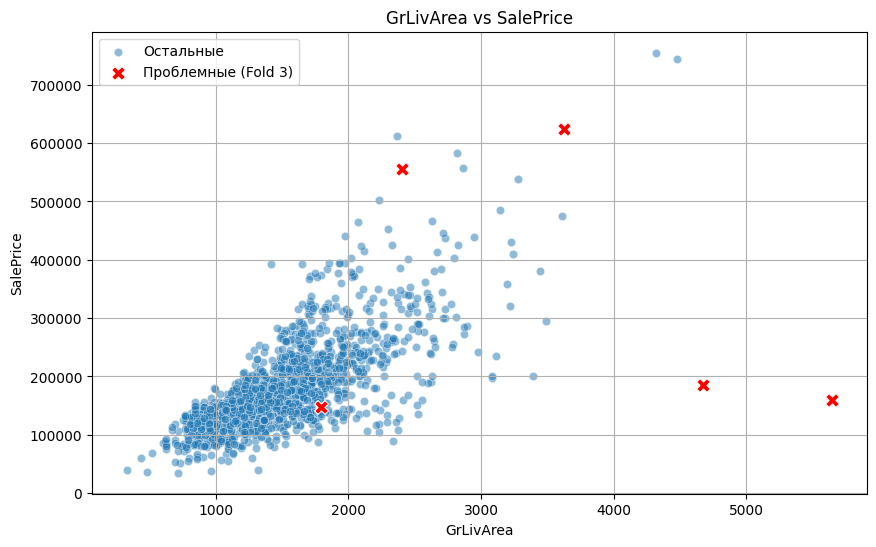

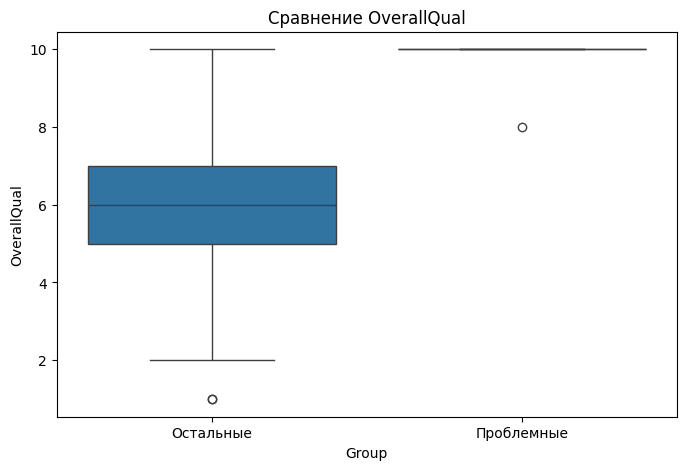

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns


# Пример: Scatter plot GrLivArea vs SalePrice
plt.figure(figsize=(10, 6))
# Сначала рисуем все точки
sns.scatterplot(x=X.loc[rest_indices, 'GrLivArea'], y=y.loc[rest_indices], label='Остальные', alpha=0.5)
# Затем выделяем проблемные
sns.scatterplot(x=X.loc[problematic_indices, 'GrLivArea'], y=y.loc[problematic_indices], color='red', s=100, label='Проблемные (Fold 3)', marker='X')
plt.title('GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.legend()
plt.grid(True)
plt.show()

# Пример: Box plot для OverallQual
plt.figure(figsize=(8, 5))
# Создаем временный DataFrame для удобства
plot_df = X[['OverallQual']].copy()
plot_df['Group'] = np.where(plot_df.index.isin(problematic_indices), 'Проблемные', 'Остальные')
sns.boxplot(x='Group', y='OverallQual', data=plot_df)
plt.title('Сравнение OverallQual')
plt.show()

## 3. Обучаем модель с CV и корректируя данные

In [46]:
# --- Логарифмирование целевой переменной ---
# y_log = np.log1p(y)

#### Нормализация данных через ColumnTransformer и Pipeline
В данном кейсе мы реализуем Заполнение числовых пропусков с помощью модели (Predictive imputation). Т.е. то, что пропущено в числовых признаках - будем заполнять не медианой или средним, а будем обучать модель, которая будет предсказывать пропуски (IterativeImputer + RandomForestRegressor)

In [47]:
# Создаем preprocessor с разными трансформерами для разных типов данных
# Числовые данные пропущенные предсказываем с помощью модели RandomForestRegressor

# Пайплайн для числовых признаков (итеративное заполнение)
numeric_transformer = Pipeline(steps=[
    # ('imputer', IterativeImputer(
    #     estimator=RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE),
    #     max_iter=10,
    #     random_state=RANDOM_STATE
    # )),
    ('imputer', SimpleImputer(strategy='mean')),
    # ('scaler', StandardScaler())
])

# Пайплайн для категориальных признаков (заполнение частым значением и кодирование)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# --- Объединяем препроцессоры ---
preprocessor = ColumnTransformer(
    transformers=[
        # Применяем к исходным числовым колонкам
        ('num', numeric_transformer, numeric_columns),
        # Применяем к исходным категориальным колонкам
        ('cat', categorical_transformer, non_numeric_columns)
    ],
    remainder='drop',   # 'passthrough' сохранит полиномиальные и другие колонки, которые не были ни числовыми, ни категориальными ИЗНАЧАЛЬНО
    verbose_feature_names_out=False  # Чтобы имена колонок не менялись на 'num__colname' и т.д.
)

default_params = {
    'iterations': 1000, 
    'learning_rate': 0.05, 
    'depth': 6, 
    'loss_function': 'RMSE', 
    'verbose': 0, 
    'random_seed': RANDOM_STATE,
    # 'early_stopping_rounds': 100  # ?
}
catboost_params = {
    'iterations': 3000,  # Увеличиваем запас итераций, учитывая early_stopping
    'learning_rate': 0.03,
    'depth': 6,
    'loss_function': 'RMSE', # Оптимизируем RMSE на логарифмированной шкале
    'verbose': 0,
    'random_seed': RANDOM_STATE,
    'early_stopping_rounds': 100 # Включаем early stopping
}
optuna_best_params = {
    'iterations': 2279,
    'depth': 5,
    'learning_rate': 0.01489174151229139,
    'l2_leaf_reg': 2.3495954457881623,
    'bagging_temperature': 0.9217322652060611,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 500
}
catboost_params = optuna_best_params

# Включить Early Stopping очень рекомендуется в параметрах. Это позволит модели на каждом фолде останавливаться тогда, когда метрика на валидационной части этого фолда (X_val, y_val_log) перестает улучшаться. Это самый надежный способ подобрать оптимальное число итераций для каждого фолда и избежать переобучения

# --- Финальный пайплайн ---
# Мы будем использовать preprocessor и модель отдельно в цикле CV
# для корректной работы early stopping с пайплайном sklearn. Поэтому нам финальный пайплайн - не нужен.
# final_pipeline = Pipeline([
#     ('preprocessing', preprocessor),
#     ('model', CatBoostRegressor(**catboost_params))
# ])

In [50]:
"""
Пояснения к тому, что тут происходит:

По сути - тут у нас прогон по разным фолдам, где мы обучаем модель на трейне и валидируем на валидации. Определяя на какой итерации остановиться (early stopping) и получаем предсказания на валидации и тесте. Потом, получив итерацию, на которой остановились, мы можем сделать предсказания на тесте, обучив модель на всех данных.

oof_predictions — это массив, который в итоге будет содержать предсказания для каждого объекта из исходного тренировочного набора (X). Важно, что предсказание для конкретного объекта (например, дома №100) делается той моделью (из цикла CV), которая обучалась без этого объекта. Надежная оценка качества: OOF-предикты позволяют посчитать метрику качества (например, oof_rmse) на всем тренировочном наборе, при этом каждое предсказание было сделано "честно" (модель не видела этот объект при обучении). 
Эта оценка часто бывает более надежной, чем простое усреднение метрик по фолдам (mean_cv_rmse), так как она считается на полном наборе данных один раз. 
Можно сравнить oof_predictions с реальными значениями y_log (или y), чтобы понять, на каких объектах модель ошибается сильнее всего.
Стэкинг/Блендинг: OOF-предикты часто используются как новые признаки для обучения модели второго уровня (мета-модели) в ансамблях (стэкинг).

Как генерируются данные для сабмишна:
1. Модель обучается на своей части тренировочных данных (X_train, y_train_log).
2. Эта обученная модель делает предсказания на всем тестовом наборе test_X.
3. Усреднение: Ключевая строка здесь: test_predictions_log += test_preds_fold_log / N_FOLDS. Она накапливает сумму предсказаний со всех фолдов, деленных на их количество. То есть, после завершения цикла test_predictions_log будет содержать среднее арифметическое предсказаний от всех N_FOLDS моделей, обученных на разных частях тренировочных данных. 

Усреднение vs. Обучение на всех данных: Обучить модель на всех данных (X, y_log) после цикла и сделать предсказание — это тоже валидный и часто используемый подход. Плюсы: модель использует максимум данных. Минусы: это требует дополнительного шага обучения; иногда ансамбль (усреднение предсказаний с фолдов) показывает себя немного лучше на тесте за счет большей стабильности и разнообразия моделей. Выбор между этими двумя подходами часто зависит от конкретной задачи и данных, стоит пробовать оба. 
"""

# --- Кросс-Валидация ---
N_FOLDS = 5  # Например, 5 или 10
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

oof_predictions = np.zeros(X.shape[0])  # Для хранения out-of-fold предсказаний
test_predictions = np.zeros(test_data.shape[0])  # Для хранения предсказаний на тесте
fold_rmses = []
fold_best_iterations = []  # Будем сохранять лучшие итерации

# Есть проблемные фолды, на 3 - очень высокая ошибка, на 5 - очень низкая, надо дебагать
TARGET_FOLD_INDEX = 2  # 0-based index for Fold 3

mlflow.set_experiment("Final Version With CV LogTransform EarlyStopping v4")
with mlflow.start_run() as run:  # Сохраняем run для логирования артефактов
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)): 
        if fold == TARGET_FOLD_INDEX:
            # Код для eval и early_stopping без исопльзования pipeline, только preprocessor
            print(f"--- Fold {fold+1}/{N_FOLDS} ---")
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
            # 1. Обучаем препроцессор ТОЛЬКО на трейне текущего фолда
            preprocessor.fit(X_train)
    
            # 2. Трансформируем трейн и валидацию
            X_train_prep = preprocessor.transform(X_train)
            X_val_prep = preprocessor.transform(X_val)
            # Трансформируем тест (препроцессор уже обучен)
            X_test_prep = preprocessor.transform(X_test)
    
            # 3. Обучаем модель с early stopping
            model = CatBoostRegressor(**catboost_params)
            model.fit(X_train_prep, y_train,
                      eval_set=[(X_val_prep, y_val)],
                      verbose=100
                     )
    
            # Сохраняем лучшую итерацию
            best_iter = model.get_best_iteration()
            fold_best_iterations.append(best_iter)
            print(f"Best iteration for fold {fold+1}: {best_iter}")
    
            # 4. Предсказания на валидации и тесте
            val_preds = model.predict(X_val_prep)
            test_preds_fold = model.predict(X_test_prep)
    
            # 5. Сохраняем OOF и усредняем тестовые предсказания
            oof_predictions[val_idx] = val_preds
            test_predictions += test_preds_fold / N_FOLDS
    
            # 6. Оценка на фолде (в исходной шкале)
            fold_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
            print(f"Fold {fold+1} RMSE: {fold_rmse}")
            fold_rmses.append(fold_rmse)
            mlflow.log_metric(f"fold_{fold+1}_rmse", fold_rmse, step=fold+1)
            mlflow.log_metric(f"fold_{fold+1}_best_iter", best_iter, step=fold+1)
            
            # --- Дополнительный анализ для дебага конкретного фолда ---
            # Например, посмотреть на самые большие ошибки
            errors = np.abs(y_val - val_preds)
            error_df = pd.DataFrame({'Actual': y_val, 'Predicted': val_preds, 'Error': errors}).sort_values(by='Error', ascending=False)
            print("\nTop 5 errors for this fold:")
            print(error_df.head())
            # Можно также посмотреть на сами данные X_val для этих объектов
            print("\nData for top 5 error objects:")
            print(X_val.loc[error_df.head().index])
            # ---------------------------------------------
    
    # --- Итоговая оценка CV ---
    mean_cv_rmse = np.mean(fold_rmses)
    std_cv_rmse = np.std(fold_rmses)
    oof_rmse = np.sqrt(mean_squared_error(y, oof_predictions))

    print(f"\nMean CV RMSE: {mean_cv_rmse:.4f} +/- {std_cv_rmse:.4f}")
    print(f"OOF RMSE: {oof_rmse:.4f}")
    print(f"Mean best iteration: {np.mean(fold_best_iterations):.0f}")

    # Логгирование итоговых метрик вручную
    mlflow.log_metric("mean_cv_rmse", mean_cv_rmse)
    mlflow.log_metric("std_cv_rmse", std_cv_rmse)
    mlflow.log_metric("oof_rmse", oof_rmse)
    mlflow.log_metric("mean_best_iteration", np.mean(fold_best_iterations))

--- Fold 3/5 ---
0:	learn: 79871.8677046	test: 73632.3125693	best: 73632.3125693 (0)	total: 1.8ms	remaining: 4.1s
100:	learn: 37856.9109336	test: 40561.5544499	best: 40561.5544499 (100)	total: 102ms	remaining: 2.19s
200:	learn: 25803.8975931	test: 37718.2257305	best: 37573.9664832 (187)	total: 197ms	remaining: 2.04s
300:	learn: 21279.3696027	test: 39509.9767454	best: 37573.9664832 (187)	total: 288ms	remaining: 1.89s
400:	learn: 19022.4155003	test: 40426.7039760	best: 37573.9664832 (187)	total: 382ms	remaining: 1.79s
500:	learn: 17597.0121089	test: 41102.1200419	best: 37573.9664832 (187)	total: 476ms	remaining: 1.69s
600:	learn: 16490.1977155	test: 41392.4117371	best: 37573.9664832 (187)	total: 570ms	remaining: 1.59s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 37573.96648
bestIteration = 187

Shrink model to first 188 iterations.
Best iteration for fold 3: 187
Fold 3 RMSE: 37573.96648319046

Top 5 errors for this fold:
      Actual      Predicted          Error
52

In [18]:
# К чему стремимся
# Best iteration for fold 2: 2275
# Fold 2 RMSE: 23567.198823109222
# --- Fold 3/5 ---
# Best iteration for fold 3: 176
# Fold 3 RMSE: 37891.56150497079
# --- Fold 4/5 ---
# Best iteration for fold 4: 2277
# Fold 4 RMSE: 25294.866155369764
# --- Fold 5/5 ---
# Best iteration for fold 5: 2245
# Fold 5 RMSE: 18301.60539941222
# 
# Mean CV RMSE: 26078.5505 +/- 6442.0226
# OOF RMSE: 26862.4357
# Mean best iteration: 1848


In [16]:
# --- Опционально: Финальное обучение на всех данных ---
# Можно попробовать сделать результаты еще и так
final_iterations = int(np.mean(fold_best_iterations)) # Берем среднее по фолдам
print(f"\nTraining final model on all data with {final_iterations} iterations...")
final_catboost_params = catboost_params.copy()
final_catboost_params['iterations'] = final_iterations
# Убираем early stopping для финального обучения
if 'early_stopping_rounds' in final_catboost_params:
    del final_catboost_params['early_stopping_rounds']

final_model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', CatBoostRegressor(**final_catboost_params))
])

final_model_pipeline.fit(X, y)
print("Final model trained.")


Training final model on all data with 1847 iterations...
Final model trained.


['final_house_price_model.joblib']

In [17]:
# Предсказание на тесте финальной моделью (альтернатива усреднению)
final_test_pred_single_model = final_model_pipeline.predict(X_test)
submission_single = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': final_test_pred_single_model})
submission_single.to_csv('submission_final_v2.csv', index=False)
print("\nSubmission file from single final model ready.")


Submission file from single final model ready.


# ИТОГО
Выше мы получили корректный код с K-FOLD валидацией, логарифмированием целевой переменной и предсказанием. Теперь его надо оптимизировать. Попробуем optuna.

In [16]:
import optuna

# Определяем KFold один раз вне objective
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# --- Функция цели для Optuna ---
def objective(trial):
    """Функция, которую Optuna будет минимизировать."""

    # 1. Определяем подбираемые параметры CatBoost
    catboost_params = {
        'iterations': trial.suggest_int('iterations', 1000, 4000), # Даем запас для early stopping
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True), # Логарифмическая шкала часто лучше для LR
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True), # Логарифмическая шкала для регуляризации
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0), # Параметр для контроля случайности бутстрэпа
        # Можно добавить другие параметры: 'colsample_bylevel', 'subsample', 'border_count' и т.д.
        'loss_function': 'RMSE',
        'verbose': 0, # Отключаем вывод CatBoost внутри objective
        'random_seed': RANDOM_STATE,
        'early_stopping_rounds': 100 # Фиксированное значение для early stopping
    }

    fold_rmses = [] # Список для хранения RMSE по фолдам для текущего trial

    # 2. Запускаем цикл KFold CV
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_log)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train_log, y_val_log = y_log.iloc[train_idx], y_log.iloc[val_idx]

        try:
            # 3. Препроцессинг (fit на трейне, transform на трейне и валидации)
            # Важно: используем копию препроцессора или fit/transform в каждом фолде
            # Если preprocessor - это ColumnTransformer, он обучается быстро
            preprocessor.fit(X_train)
            X_train_prep = preprocessor.transform(X_train)
            X_val_prep = preprocessor.transform(X_val)

            # 4. Обучение модели CatBoost
            model = CatBoostRegressor(**catboost_params)
            model.fit(X_train_prep, y_train_log,
                      eval_set=[(X_val_prep, y_val_log)],
                      verbose=0 # Отключаем вывод
                     )

            # 5. Предсказание и оценка
            val_preds_log = model.predict(X_val_prep)
            # Преобразуем обратно в исходную шкалу
            val_preds_orig = np.expm1(val_preds_log)
            y_val_orig = np.expm1(y_val_log)
            # Обработка возможных отрицательных значений после expm1 (хотя маловероятно с log1p)
            val_preds_orig[val_preds_orig < 0] = 0
            fold_rmse = np.sqrt(mean_squared_error(y_val_orig, val_preds_orig))
            fold_rmses.append(fold_rmse)

            # 6. Отчет для Optuna Pruning (опционально, но полезно для долгих подборов)
            # Сообщаем Optuna промежуточный результат (RMSE на текущем фолде)
            trial.report(fold_rmse, step=fold)

            # Проверяем, нужно ли досрочно остановить текущий trial (если он явно плохой)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        except Exception as e:
             print(f"Error during fold {fold+1} for trial {trial.number}: {e}")
             # Если фолд не удался, возвращаем очень большое значение, чтобы Optuna считала этот trial плохим
             return float('inf')

    # 7. Возвращаем средний RMSE по всем фолдам (Optuna будет это минимизировать)
    mean_rmse = np.mean(fold_rmses)
    print(f"Trial {trial.number} finished with Mean CV RMSE: {mean_rmse:.4f}")
    return mean_rmse

# --- Запуск исследования Optuna ---
# Создаем исследование, указываем направление оптимизации (minimize)
# Pruner - механизм для досрочной остановки плохих trials
study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)) # Начинаем проверку на prune после 2 фолдов

# Запускаем оптимизацию, n_trials - количество попыток подбора параметров
N_TRIALS = 200 # Например, 50 или 100
study.optimize(objective, n_trials=N_TRIALS, n_jobs=1) # n_jobs=-1 может конфликтовать с CatBoost/MLflow, лучше 1

# --- Результаты ---
print("\nOptimization Finished!")
print(f"Number of finished trials: {len(study.trials)}")

best_trial = study.best_trial
print("Best trial:")
print(f"  Value (Mean CV RMSE): {best_trial.value:.4f}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Сохраняем лучшие параметры для использования в финальном обучении
best_params = best_trial.params
# Добавляем параметры, которые не подбирались, но нужны для модели
best_params['loss_function'] = 'RMSE'
best_params['random_seed'] = RANDOM_STATE
best_params['verbose'] = 0
# Early stopping не нужен при финальном обучении с фиксированным числом итераций
# best_params['early_stopping_rounds'] = 100 # Или можно использовать best_iteration из trial? Optuna не хранит это напрямую

# Логгирование лучших параметров в MLflow (если нужно)
# try:
#     with mlflow.start_run(run_id=run.info.run_id): # Используем предыдущий run или создаем новый
#          mlflow.log_params({f"best_{k}": v for k, v in best_trial.params.items()})
#          mlflow.log_metric("best_cv_rmse_optuna", best_trial.value)
# except Exception as e:
#     print(f"Could not log best Optuna params to MLflow: {e}")

# Теперь можно использовать best_params для финального обучения модели
# (либо на всех данных с подобранным числом итераций,
# либо в цикле CV с этими параметрами для генерации сабмишна)

[I 2025-04-02 23:54:35,876] A new study created in memory with name: no-name-d25be354-9564-4677-ae16-aa17262750d5
[I 2025-04-02 23:54:40,019] Trial 0 finished with value: 26774.68633421593 and parameters: {'iterations': 2035, 'depth': 4, 'learning_rate': 0.03746270467239184, 'l2_leaf_reg': 3.979194388787327, 'bagging_temperature': 0.11655891144766806}. Best is trial 0 with value: 26774.68633421593.


Trial 0 finished with Mean CV RMSE: 26774.6863


[I 2025-04-02 23:54:47,055] Trial 1 finished with value: 26756.206261445397 and parameters: {'iterations': 1084, 'depth': 6, 'learning_rate': 0.03691551498362596, 'l2_leaf_reg': 7.135837611128692, 'bagging_temperature': 0.5165345602611249}. Best is trial 1 with value: 26756.206261445397.


Trial 1 finished with Mean CV RMSE: 26756.2063


[I 2025-04-02 23:55:10,358] Trial 2 finished with value: 26854.743496323546 and parameters: {'iterations': 2633, 'depth': 7, 'learning_rate': 0.014882085035641372, 'l2_leaf_reg': 1.0339710914195908, 'bagging_temperature': 0.18167924817042236}. Best is trial 1 with value: 26756.206261445397.


Trial 2 finished with Mean CV RMSE: 26854.7435


[I 2025-04-02 23:55:20,415] Trial 3 finished with value: 26757.344596158036 and parameters: {'iterations': 3599, 'depth': 6, 'learning_rate': 0.01815340251126415, 'l2_leaf_reg': 2.3789556820602757, 'bagging_temperature': 0.6700487571529643}. Best is trial 1 with value: 26756.206261445397.


Trial 3 finished with Mean CV RMSE: 26757.3446


[I 2025-04-02 23:55:28,988] Trial 4 finished with value: 26070.146990687546 and parameters: {'iterations': 2717, 'depth': 4, 'learning_rate': 0.010365749085148361, 'l2_leaf_reg': 1.2785110961327049, 'bagging_temperature': 0.31333401330281996}. Best is trial 4 with value: 26070.146990687546.


Trial 4 finished with Mean CV RMSE: 26070.1470


[I 2025-04-02 23:56:15,122] Trial 5 finished with value: inf and parameters: {'iterations': 2608, 'depth': 10, 'learning_rate': 0.03901869661908207, 'l2_leaf_reg': 1.870178182700264, 'bagging_temperature': 0.06651857736591515}. Best is trial 4 with value: 26070.146990687546.


Error during fold 4 for trial 5: 


[I 2025-04-02 23:56:21,576] Trial 6 finished with value: 25962.446128600524 and parameters: {'iterations': 1712, 'depth': 5, 'learning_rate': 0.029402005361880576, 'l2_leaf_reg': 3.7700560669405165, 'bagging_temperature': 0.05671291418527846}. Best is trial 6 with value: 25962.446128600524.


Trial 6 finished with Mean CV RMSE: 25962.4461


[I 2025-04-02 23:56:26,076] Trial 7 finished with value: inf and parameters: {'iterations': 2851, 'depth': 4, 'learning_rate': 0.0337910241426384, 'l2_leaf_reg': 1.1301066910285085, 'bagging_temperature': 0.14975595823983112}. Best is trial 6 with value: 25962.446128600524.


Error during fold 5 for trial 7: 


[I 2025-04-02 23:56:34,426] Trial 8 finished with value: inf and parameters: {'iterations': 2778, 'depth': 4, 'learning_rate': 0.020490221592152337, 'l2_leaf_reg': 7.107567323649183, 'bagging_temperature': 0.1762643837837896}. Best is trial 6 with value: 25962.446128600524.


Error during fold 5 for trial 8: 


[I 2025-04-02 23:57:24,573] Trial 9 finished with value: inf and parameters: {'iterations': 3437, 'depth': 9, 'learning_rate': 0.01707219620824688, 'l2_leaf_reg': 4.093095756159052, 'bagging_temperature': 0.8708643697937746}. Best is trial 6 with value: 25962.446128600524.


Error during fold 4 for trial 9: 


[I 2025-04-02 23:57:29,492] Trial 10 finished with value: inf and parameters: {'iterations': 1560, 'depth': 6, 'learning_rate': 0.08156958759477215, 'l2_leaf_reg': 9.240564508360968, 'bagging_temperature': 0.3897708461884487}. Best is trial 6 with value: 25962.446128600524.


Error during fold 5 for trial 10: 


[I 2025-04-02 23:57:38,950] Trial 11 finished with value: 26267.686486716913 and parameters: {'iterations': 1906, 'depth': 5, 'learning_rate': 0.011094218596371197, 'l2_leaf_reg': 1.8315616986189192, 'bagging_temperature': 0.39085129513560013}. Best is trial 6 with value: 25962.446128600524.


Trial 11 finished with Mean CV RMSE: 26267.6865


[I 2025-04-02 23:57:43,299] Trial 12 finished with value: 25748.435084629116 and parameters: {'iterations': 2135, 'depth': 5, 'learning_rate': 0.06390943438097839, 'l2_leaf_reg': 2.8726199178605705, 'bagging_temperature': 0.3066316848268256}. Best is trial 12 with value: 25748.435084629116.


Trial 12 finished with Mean CV RMSE: 25748.4351


[I 2025-04-02 23:57:55,294] Trial 13 finished with value: inf and parameters: {'iterations': 2028, 'depth': 8, 'learning_rate': 0.06500488098827606, 'l2_leaf_reg': 3.21126864639848, 'bagging_temperature': 0.5717916472208409}. Best is trial 12 with value: 25748.435084629116.


Error during fold 4 for trial 13: 


[I 2025-04-02 23:57:59,607] Trial 14 finished with value: inf and parameters: {'iterations': 1366, 'depth': 5, 'learning_rate': 0.05596002063812794, 'l2_leaf_reg': 5.097806782293412, 'bagging_temperature': 0.02906438242843712}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 14: 


[I 2025-04-02 23:58:14,291] Trial 15 finished with value: 26990.21842987291 and parameters: {'iterations': 2211, 'depth': 7, 'learning_rate': 0.025226256067154736, 'l2_leaf_reg': 2.6284096709246247, 'bagging_temperature': 0.28812674802724314}. Best is trial 12 with value: 25748.435084629116.


Trial 15 finished with Mean CV RMSE: 26990.2184


[I 2025-04-02 23:58:17,644] Trial 16 finished with value: 26134.696627740697 and parameters: {'iterations': 1640, 'depth': 5, 'learning_rate': 0.09254336072382038, 'l2_leaf_reg': 5.052383434325277, 'bagging_temperature': 0.7231633445981426}. Best is trial 12 with value: 25748.435084629116.


Trial 16 finished with Mean CV RMSE: 26134.6966


[I 2025-04-02 23:58:22,710] Trial 17 finished with value: 25816.715507045625 and parameters: {'iterations': 3198, 'depth': 5, 'learning_rate': 0.04850813614470458, 'l2_leaf_reg': 3.324309265586686, 'bagging_temperature': 0.28299252572335953}. Best is trial 12 with value: 25748.435084629116.


Trial 17 finished with Mean CV RMSE: 25816.7155


[I 2025-04-02 23:58:34,971] Trial 18 finished with value: 27420.048905514344 and parameters: {'iterations': 3175, 'depth': 8, 'learning_rate': 0.0553865128070114, 'l2_leaf_reg': 1.905145466288808, 'bagging_temperature': 0.28702531841268847}. Best is trial 12 with value: 25748.435084629116.


Trial 18 finished with Mean CV RMSE: 27420.0489


[I 2025-04-02 23:58:42,121] Trial 19 finished with value: inf and parameters: {'iterations': 3181, 'depth': 6, 'learning_rate': 0.04659268928157478, 'l2_leaf_reg': 2.611472193126278, 'bagging_temperature': 0.4261357834416213}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 19: 


[I 2025-04-02 23:58:48,504] Trial 20 finished with value: inf and parameters: {'iterations': 3886, 'depth': 7, 'learning_rate': 0.07272352993272878, 'l2_leaf_reg': 5.1982088677268266, 'bagging_temperature': 0.9634523826784391}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 20: 


[I 2025-04-02 23:58:55,643] Trial 21 finished with value: inf and parameters: {'iterations': 2317, 'depth': 5, 'learning_rate': 0.026852215493410436, 'l2_leaf_reg': 3.6106949886543545, 'bagging_temperature': 0.006655501248109347}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 21: 


[I 2025-04-02 23:58:59,772] Trial 22 finished with value: 26391.44587540974 and parameters: {'iterations': 1761, 'depth': 5, 'learning_rate': 0.04609397369321567, 'l2_leaf_reg': 2.895390990197029, 'bagging_temperature': 0.246860630179433}. Best is trial 12 with value: 25748.435084629116.


Trial 22 finished with Mean CV RMSE: 26391.4459


[I 2025-04-02 23:59:08,714] Trial 23 finished with value: inf and parameters: {'iterations': 2362, 'depth': 6, 'learning_rate': 0.027595487028876407, 'l2_leaf_reg': 2.319075933784032, 'bagging_temperature': 0.21143498435378633}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 23: 


[I 2025-04-02 23:59:13,601] Trial 24 finished with value: 26287.388806795458 and parameters: {'iterations': 1338, 'depth': 5, 'learning_rate': 0.04682267292580056, 'l2_leaf_reg': 3.432444854792184, 'bagging_temperature': 0.3544008628010052}. Best is trial 12 with value: 25748.435084629116.


Trial 24 finished with Mean CV RMSE: 26287.3888


[I 2025-04-02 23:59:16,224] Trial 25 finished with value: inf and parameters: {'iterations': 3044, 'depth': 4, 'learning_rate': 0.06014033008319523, 'l2_leaf_reg': 4.4131530604366205, 'bagging_temperature': 0.48549014463463264}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 25: 


[I 2025-04-02 23:59:18,707] Trial 26 finished with value: 26023.741465778992 and parameters: {'iterations': 1019, 'depth': 5, 'learning_rate': 0.07289014491017347, 'l2_leaf_reg': 1.6141734195195097, 'bagging_temperature': 0.09254818750178587}. Best is trial 12 with value: 25748.435084629116.


Trial 26 finished with Mean CV RMSE: 26023.7415


[I 2025-04-02 23:59:30,511] Trial 27 finished with value: 26568.572722604767 and parameters: {'iterations': 2193, 'depth': 6, 'learning_rate': 0.02296848049968388, 'l2_leaf_reg': 6.218162049229871, 'bagging_temperature': 0.21739264254945578}. Best is trial 12 with value: 25748.435084629116.


Trial 27 finished with Mean CV RMSE: 26568.5727


[I 2025-04-02 23:59:39,323] Trial 28 finished with value: inf and parameters: {'iterations': 2490, 'depth': 8, 'learning_rate': 0.09821529995561971, 'l2_leaf_reg': 3.132271383833707, 'bagging_temperature': 0.6114354112376708}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 28: 


[I 2025-04-02 23:59:44,142] Trial 29 finished with value: inf and parameters: {'iterations': 3996, 'depth': 4, 'learning_rate': 0.029296975517052987, 'l2_leaf_reg': 3.9988584228843114, 'bagging_temperature': 0.128644819001481}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 29: 


[I 2025-04-02 23:59:47,846] Trial 30 finished with value: inf and parameters: {'iterations': 1915, 'depth': 4, 'learning_rate': 0.038880485819701514, 'l2_leaf_reg': 2.272612527133536, 'bagging_temperature': 0.09308750180214737}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 30: 


[I 2025-04-02 23:59:50,801] Trial 31 finished with value: 26042.348181272002 and parameters: {'iterations': 1062, 'depth': 5, 'learning_rate': 0.07345001020068971, 'l2_leaf_reg': 1.5664424340267664, 'bagging_temperature': 0.0836819526181196}. Best is trial 12 with value: 25748.435084629116.


Trial 31 finished with Mean CV RMSE: 26042.3482


[I 2025-04-02 23:59:54,819] Trial 32 finished with value: 26329.804611333813 and parameters: {'iterations': 1292, 'depth': 5, 'learning_rate': 0.05277348926118093, 'l2_leaf_reg': 1.4953353710398518, 'bagging_temperature': 0.47343739377415234}. Best is trial 12 with value: 25748.435084629116.


Trial 32 finished with Mean CV RMSE: 26329.8046


[I 2025-04-03 00:00:03,522] Trial 33 finished with value: 26490.622650065587 and parameters: {'iterations': 1545, 'depth': 7, 'learning_rate': 0.06731216451868544, 'l2_leaf_reg': 4.5411271558942445, 'bagging_temperature': 0.14417996924403143}. Best is trial 12 with value: 25748.435084629116.


Trial 33 finished with Mean CV RMSE: 26490.6227


[I 2025-04-03 00:00:06,823] Trial 34 finished with value: inf and parameters: {'iterations': 1188, 'depth': 6, 'learning_rate': 0.08117480290438389, 'l2_leaf_reg': 3.6547956927701093, 'bagging_temperature': 0.006596887831309697}. Best is trial 12 with value: 25748.435084629116.


Error during fold 4 for trial 34: 


[I 2025-04-03 00:00:12,145] Trial 35 finished with value: 25979.429890195574 and parameters: {'iterations': 1846, 'depth': 5, 'learning_rate': 0.032214337559816966, 'l2_leaf_reg': 2.0633784148468077, 'bagging_temperature': 0.23588788168981822}. Best is trial 12 with value: 25748.435084629116.


Trial 35 finished with Mean CV RMSE: 25979.4299


[I 2025-04-03 00:00:16,309] Trial 36 finished with value: inf and parameters: {'iterations': 1765, 'depth': 4, 'learning_rate': 0.03308648195776443, 'l2_leaf_reg': 2.0510892812912305, 'bagging_temperature': 0.32972939557701214}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 36: 


[I 2025-04-03 00:00:23,459] Trial 37 finished with value: 26037.79855719142 and parameters: {'iterations': 2022, 'depth': 6, 'learning_rate': 0.04104054533160489, 'l2_leaf_reg': 2.904966479521976, 'bagging_temperature': 0.2292610904941547}. Best is trial 12 with value: 25748.435084629116.


Trial 37 finished with Mean CV RMSE: 26037.7986


[I 2025-04-03 00:00:27,137] Trial 38 finished with value: inf and parameters: {'iterations': 3452, 'depth': 4, 'learning_rate': 0.03467809325019289, 'l2_leaf_reg': 2.7793321179485946, 'bagging_temperature': 0.2879476215060872}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 38: 


[I 2025-04-03 00:00:31,071] Trial 39 finished with value: 25799.944909442056 and parameters: {'iterations': 2911, 'depth': 5, 'learning_rate': 0.04225890954552186, 'l2_leaf_reg': 2.241858491633208, 'bagging_temperature': 0.17230617374247198}. Best is trial 12 with value: 25748.435084629116.


Trial 39 finished with Mean CV RMSE: 25799.9449


[I 2025-04-03 00:01:07,341] Trial 40 finished with value: inf and parameters: {'iterations': 3035, 'depth': 10, 'learning_rate': 0.04212780862695297, 'l2_leaf_reg': 2.3674443434296846, 'bagging_temperature': 0.17519797535719212}. Best is trial 12 with value: 25748.435084629116.


Error during fold 4 for trial 40: 


[I 2025-04-03 00:01:12,843] Trial 41 finished with value: 26134.390839781823 and parameters: {'iterations': 2902, 'depth': 5, 'learning_rate': 0.03188028714082334, 'l2_leaf_reg': 2.106201183370147, 'bagging_temperature': 0.26112808406311777}. Best is trial 12 with value: 25748.435084629116.


Trial 41 finished with Mean CV RMSE: 26134.3908


[I 2025-04-03 00:01:23,263] Trial 42 finished with value: 26258.34580397505 and parameters: {'iterations': 2472, 'depth': 6, 'learning_rate': 0.023022148629557492, 'l2_leaf_reg': 3.2565056754199984, 'bagging_temperature': 0.17462049756241632}. Best is trial 12 with value: 25748.435084629116.


Trial 42 finished with Mean CV RMSE: 26258.3458


[I 2025-04-03 00:01:27,408] Trial 43 finished with value: 25758.330827727175 and parameters: {'iterations': 2673, 'depth': 5, 'learning_rate': 0.048647692989205626, 'l2_leaf_reg': 1.7157556312134117, 'bagging_temperature': 0.3638816362501336}. Best is trial 12 with value: 25748.435084629116.


Trial 43 finished with Mean CV RMSE: 25758.3308


[I 2025-04-03 00:01:30,646] Trial 44 finished with value: inf and parameters: {'iterations': 2721, 'depth': 4, 'learning_rate': 0.0524023635068651, 'l2_leaf_reg': 1.3516351454368951, 'bagging_temperature': 0.4287287872247156}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 44: 


[I 2025-04-03 00:01:36,002] Trial 45 finished with value: 26437.07893845272 and parameters: {'iterations': 2576, 'depth': 6, 'learning_rate': 0.04450607682363838, 'l2_leaf_reg': 1.0056746892992796, 'bagging_temperature': 0.3357363443747623}. Best is trial 12 with value: 25748.435084629116.


Trial 45 finished with Mean CV RMSE: 26437.0789


[I 2025-04-03 00:01:41,009] Trial 46 finished with value: 26010.200704858875 and parameters: {'iterations': 3401, 'depth': 5, 'learning_rate': 0.036022508217831935, 'l2_leaf_reg': 1.7203225403586266, 'bagging_temperature': 0.38544716644560356}. Best is trial 12 with value: 25748.435084629116.


Trial 46 finished with Mean CV RMSE: 26010.2007


[I 2025-04-03 00:01:44,329] Trial 47 finished with value: inf and parameters: {'iterations': 2904, 'depth': 4, 'learning_rate': 0.05162456107683395, 'l2_leaf_reg': 1.2285188344718874, 'bagging_temperature': 0.05589421976394124}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 47: 


[I 2025-04-03 00:02:00,105] Trial 48 finished with value: inf and parameters: {'iterations': 3685, 'depth': 9, 'learning_rate': 0.06064144258414101, 'l2_leaf_reg': 2.565155849078849, 'bagging_temperature': 0.44152446376377563}. Best is trial 12 with value: 25748.435084629116.


Error during fold 4 for trial 48: 


[I 2025-04-03 00:02:10,374] Trial 49 finished with value: 25830.337450716615 and parameters: {'iterations': 3215, 'depth': 5, 'learning_rate': 0.018166568653719697, 'l2_leaf_reg': 4.45607460208669, 'bagging_temperature': 0.3604332335844899}. Best is trial 12 with value: 25748.435084629116.


Trial 49 finished with Mean CV RMSE: 25830.3375


[I 2025-04-03 00:02:29,825] Trial 50 finished with value: inf and parameters: {'iterations': 3295, 'depth': 6, 'learning_rate': 0.012624597136875495, 'l2_leaf_reg': 6.42490460280783, 'bagging_temperature': 0.54593264032671}. Best is trial 12 with value: 25748.435084629116.


Error during fold 5 for trial 50: 


[I 2025-04-03 00:02:39,264] Trial 51 finished with value: 25802.38449074608 and parameters: {'iterations': 3048, 'depth': 5, 'learning_rate': 0.017317479876544816, 'l2_leaf_reg': 3.770613100602562, 'bagging_temperature': 0.37336586564220076}. Best is trial 12 with value: 25748.435084629116.


Trial 51 finished with Mean CV RMSE: 25802.3845


[I 2025-04-03 00:02:48,370] Trial 52 finished with value: 25760.40120728955 and parameters: {'iterations': 3061, 'depth': 5, 'learning_rate': 0.016984529737432873, 'l2_leaf_reg': 4.513407479612444, 'bagging_temperature': 0.3694605724127213}. Best is trial 12 with value: 25748.435084629116.


Trial 52 finished with Mean CV RMSE: 25760.4012


[I 2025-04-03 00:03:00,666] Trial 53 finished with value: 25704.020832558854 and parameters: {'iterations': 3024, 'depth': 5, 'learning_rate': 0.014677208364288898, 'l2_leaf_reg': 3.9717414493929324, 'bagging_temperature': 0.286163972250425}. Best is trial 53 with value: 25704.020832558854.


Trial 53 finished with Mean CV RMSE: 25704.0208


[I 2025-04-03 00:03:11,934] Trial 54 finished with value: 25926.31299659891 and parameters: {'iterations': 3019, 'depth': 5, 'learning_rate': 0.016910599870487184, 'l2_leaf_reg': 5.603746264425873, 'bagging_temperature': 0.39162547111747215}. Best is trial 53 with value: 25704.020832558854.


Trial 54 finished with Mean CV RMSE: 25926.3130


[I 2025-04-03 00:03:24,351] Trial 55 finished with value: inf and parameters: {'iterations': 2798, 'depth': 5, 'learning_rate': 0.014049990781591715, 'l2_leaf_reg': 8.934720974758518, 'bagging_temperature': 0.29079430646028775}. Best is trial 53 with value: 25704.020832558854.


Error during fold 5 for trial 55: 


[I 2025-04-03 00:03:33,468] Trial 56 finished with value: inf and parameters: {'iterations': 2648, 'depth': 4, 'learning_rate': 0.010329590999861315, 'l2_leaf_reg': 4.1507329970244635, 'bagging_temperature': 0.4444383754220187}. Best is trial 53 with value: 25704.020832558854.


Error during fold 5 for trial 56: 


[I 2025-04-03 00:03:50,563] Trial 57 finished with value: 26377.477912081864 and parameters: {'iterations': 2953, 'depth': 6, 'learning_rate': 0.013829497321179687, 'l2_leaf_reg': 3.880689020026167, 'bagging_temperature': 0.5031720902497654}. Best is trial 53 with value: 25704.020832558854.


Trial 57 finished with Mean CV RMSE: 26377.4779


[I 2025-04-03 00:04:12,719] Trial 58 finished with value: 26755.959624016297 and parameters: {'iterations': 2809, 'depth': 7, 'learning_rate': 0.016235756354438077, 'l2_leaf_reg': 3.0203827168186597, 'bagging_temperature': 0.31735293915732493}. Best is trial 53 with value: 25704.020832558854.


Trial 58 finished with Mean CV RMSE: 26755.9596


[I 2025-04-03 00:04:23,477] Trial 59 finished with value: 26115.048993425182 and parameters: {'iterations': 2385, 'depth': 5, 'learning_rate': 0.011940888577528305, 'l2_leaf_reg': 4.869407357523367, 'bagging_temperature': 0.3736296826412536}. Best is trial 53 with value: 25704.020832558854.


Trial 59 finished with Mean CV RMSE: 26115.0490


[I 2025-04-03 00:04:36,053] Trial 60 finished with value: inf and parameters: {'iterations': 3124, 'depth': 6, 'learning_rate': 0.02042995227358685, 'l2_leaf_reg': 3.4418594335292854, 'bagging_temperature': 0.7426618320987468}. Best is trial 53 with value: 25704.020832558854.


Error during fold 5 for trial 60: 


[I 2025-04-03 00:04:46,902] Trial 61 finished with value: 25928.756618489722 and parameters: {'iterations': 3340, 'depth': 5, 'learning_rate': 0.01509160410050508, 'l2_leaf_reg': 3.3866393704649864, 'bagging_temperature': 0.2658050503556776}. Best is trial 53 with value: 25704.020832558854.


Trial 61 finished with Mean CV RMSE: 25928.7566


[I 2025-04-03 00:04:55,513] Trial 62 finished with value: 25820.322071700437 and parameters: {'iterations': 3096, 'depth': 5, 'learning_rate': 0.019778139356100937, 'l2_leaf_reg': 2.586960617836734, 'bagging_temperature': 0.19891072862459122}. Best is trial 53 with value: 25704.020832558854.


Trial 62 finished with Mean CV RMSE: 25820.3221


[I 2025-04-03 00:05:01,271] Trial 63 finished with value: inf and parameters: {'iterations': 3542, 'depth': 5, 'learning_rate': 0.04920327890727495, 'l2_leaf_reg': 3.6660423064904863, 'bagging_temperature': 0.40582295124396106}. Best is trial 53 with value: 25704.020832558854.


Error during fold 5 for trial 63: 


[I 2025-04-03 00:05:06,157] Trial 64 finished with value: 26170.426515122068 and parameters: {'iterations': 3283, 'depth': 5, 'learning_rate': 0.05793370371935129, 'l2_leaf_reg': 4.168894055784715, 'bagging_temperature': 0.32242492572195613}. Best is trial 53 with value: 25704.020832558854.


Trial 64 finished with Mean CV RMSE: 26170.4265


[I 2025-04-03 00:05:14,111] Trial 65 finished with value: inf and parameters: {'iterations': 2676, 'depth': 4, 'learning_rate': 0.018725987340007796, 'l2_leaf_reg': 5.684143385902242, 'bagging_temperature': 0.34709661459598057}. Best is trial 53 with value: 25704.020832558854.


Error during fold 5 for trial 65: 


[I 2025-04-03 00:05:18,535] Trial 66 finished with value: 26088.518870478467 and parameters: {'iterations': 2202, 'depth': 5, 'learning_rate': 0.06581909248663616, 'l2_leaf_reg': 4.756623144554833, 'bagging_temperature': 0.2964333036628794}. Best is trial 53 with value: 25704.020832558854.


Trial 66 finished with Mean CV RMSE: 26088.5189


[I 2025-04-03 00:05:33,980] Trial 67 finished with value: 26363.685175915714 and parameters: {'iterations': 2967, 'depth': 6, 'learning_rate': 0.015186683757848327, 'l2_leaf_reg': 1.9049318589380364, 'bagging_temperature': 0.4619186606992994}. Best is trial 53 with value: 25704.020832558854.


Trial 67 finished with Mean CV RMSE: 26363.6852


[I 2025-04-03 00:05:39,603] Trial 68 finished with value: inf and parameters: {'iterations': 2762, 'depth': 4, 'learning_rate': 0.023733691303765483, 'l2_leaf_reg': 3.1092054526992774, 'bagging_temperature': 0.5314658196027651}. Best is trial 53 with value: 25704.020832558854.


Error during fold 5 for trial 68: 


[I 2025-04-03 00:05:50,677] Trial 69 finished with value: 26209.36600963772 and parameters: {'iterations': 2567, 'depth': 5, 'learning_rate': 0.012487208228009056, 'l2_leaf_reg': 3.91764711428882, 'bagging_temperature': 0.2523704251900046}. Best is trial 53 with value: 25704.020832558854.


Trial 69 finished with Mean CV RMSE: 26209.3660


[I 2025-04-03 00:05:55,421] Trial 70 finished with value: inf and parameters: {'iterations': 3144, 'depth': 5, 'learning_rate': 0.0435973350833253, 'l2_leaf_reg': 2.8233641471897677, 'bagging_temperature': 0.4073464073114219}. Best is trial 53 with value: 25704.020832558854.


Error during fold 5 for trial 70: 


[I 2025-04-03 00:06:03,955] Trial 71 finished with value: inf and parameters: {'iterations': 3090, 'depth': 5, 'learning_rate': 0.019871543952897742, 'l2_leaf_reg': 2.5285297507864484, 'bagging_temperature': 0.2043705137175248}. Best is trial 53 with value: 25704.020832558854.


Error during fold 5 for trial 71: 


[I 2025-04-03 00:06:14,770] Trial 72 finished with value: 25573.6901586271 and parameters: {'iterations': 3211, 'depth': 5, 'learning_rate': 0.01665990604836067, 'l2_leaf_reg': 2.6526891879033507, 'bagging_temperature': 0.1837708726203104}. Best is trial 72 with value: 25573.6901586271.


Trial 72 finished with Mean CV RMSE: 25573.6902


[I 2025-04-03 00:06:24,513] Trial 73 finished with value: 25584.266632936844 and parameters: {'iterations': 2870, 'depth': 5, 'learning_rate': 0.015874780562693404, 'l2_leaf_reg': 2.202795749041392, 'bagging_temperature': 0.15572103282575434}. Best is trial 72 with value: 25573.6901586271.


Trial 73 finished with Mean CV RMSE: 25584.2666


[I 2025-04-03 00:06:34,561] Trial 74 finished with value: 25611.167937327722 and parameters: {'iterations': 2916, 'depth': 5, 'learning_rate': 0.016119154842549055, 'l2_leaf_reg': 2.2391361217295667, 'bagging_temperature': 0.1518334208637134}. Best is trial 72 with value: 25573.6901586271.


Trial 74 finished with Mean CV RMSE: 25611.1679


[I 2025-04-03 00:06:48,982] Trial 75 finished with value: 26049.25594739892 and parameters: {'iterations': 2844, 'depth': 6, 'learning_rate': 0.014147449378459215, 'l2_leaf_reg': 2.185875565641541, 'bagging_temperature': 0.14448283381693452}. Best is trial 72 with value: 25573.6901586271.


Trial 75 finished with Mean CV RMSE: 26049.2559


[I 2025-04-03 00:06:55,669] Trial 76 finished with value: inf and parameters: {'iterations': 2901, 'depth': 4, 'learning_rate': 0.01583278171480819, 'l2_leaf_reg': 1.9573356618580628, 'bagging_temperature': 0.1138477608226055}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 76: 


[I 2025-04-03 00:07:53,733] Trial 77 finished with value: inf and parameters: {'iterations': 3251, 'depth': 9, 'learning_rate': 0.01115835397100702, 'l2_leaf_reg': 1.7371778415238406, 'bagging_temperature': 0.04139793748370989}. Best is trial 72 with value: 25573.6901586271.


Error during fold 4 for trial 77: 


[I 2025-04-03 00:08:04,153] Trial 78 finished with value: 26091.18981982962 and parameters: {'iterations': 2960, 'depth': 5, 'learning_rate': 0.013735738445234121, 'l2_leaf_reg': 2.459779813865806, 'bagging_temperature': 0.16654760867966406}. Best is trial 72 with value: 25573.6901586271.


Trial 78 finished with Mean CV RMSE: 26091.1898


[I 2025-04-03 00:08:12,731] Trial 79 finished with value: 25890.88804914544 and parameters: {'iterations': 2684, 'depth': 5, 'learning_rate': 0.02188004021856753, 'l2_leaf_reg': 2.2888412948996395, 'bagging_temperature': 0.10698624902865471}. Best is trial 72 with value: 25573.6901586271.


Trial 79 finished with Mean CV RMSE: 25890.8880


[I 2025-04-03 00:08:25,327] Trial 80 finished with value: inf and parameters: {'iterations': 2444, 'depth': 6, 'learning_rate': 0.016160877284788957, 'l2_leaf_reg': 2.6974243269142018, 'bagging_temperature': 0.19096977873591958}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 80: 


[I 2025-04-03 00:08:35,544] Trial 81 finished with value: inf and parameters: {'iterations': 3039, 'depth': 5, 'learning_rate': 0.01720069791596105, 'l2_leaf_reg': 1.4358469375027076, 'bagging_temperature': 0.23079865868296923}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 81: 


[I 2025-04-03 00:08:43,465] Trial 82 finished with value: 25696.462508760214 and parameters: {'iterations': 2282, 'depth': 5, 'learning_rate': 0.017519858075578796, 'l2_leaf_reg': 1.7232289748983023, 'bagging_temperature': 0.14163295041528262}. Best is trial 72 with value: 25573.6901586271.


Trial 82 finished with Mean CV RMSE: 25696.4625


[I 2025-04-03 00:08:52,816] Trial 83 finished with value: 25961.237304490067 and parameters: {'iterations': 2088, 'depth': 5, 'learning_rate': 0.012767453773521445, 'l2_leaf_reg': 1.7558672835762894, 'bagging_temperature': 0.129163356151601}. Best is trial 72 with value: 25573.6901586271.


Trial 83 finished with Mean CV RMSE: 25961.2373


[I 2025-04-03 00:09:00,722] Trial 84 finished with value: inf and parameters: {'iterations': 2086, 'depth': 5, 'learning_rate': 0.01864076424912079, 'l2_leaf_reg': 2.135302884744121, 'bagging_temperature': 0.07813473481337839}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 84: 


[I 2025-04-03 00:09:08,308] Trial 85 finished with value: inf and parameters: {'iterations': 2557, 'depth': 4, 'learning_rate': 0.01459148619943189, 'l2_leaf_reg': 1.5936650147081837, 'bagging_temperature': 0.16495992204048948}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 85: 


[I 2025-04-03 00:09:17,802] Trial 86 finished with value: inf and parameters: {'iterations': 2299, 'depth': 5, 'learning_rate': 0.013188733395871668, 'l2_leaf_reg': 2.0204102123404475, 'bagging_temperature': 0.2653933802628707}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 86: 


[I 2025-04-03 00:09:24,991] Trial 87 finished with value: inf and parameters: {'iterations': 2735, 'depth': 5, 'learning_rate': 0.021377474968092135, 'l2_leaf_reg': 1.827181480138693, 'bagging_temperature': 0.15981315455696915}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 87: 


[I 2025-04-03 00:09:28,692] Trial 88 finished with value: inf and parameters: {'iterations': 2262, 'depth': 6, 'learning_rate': 0.08030826517689411, 'l2_leaf_reg': 2.1999070218494063, 'bagging_temperature': 0.21690409341084024}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 88: 


[I 2025-04-03 00:09:32,476] Trial 89 finished with value: inf and parameters: {'iterations': 2390, 'depth': 4, 'learning_rate': 0.037481793795666074, 'l2_leaf_reg': 2.3477200036335537, 'bagging_temperature': 0.13586919238862225}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 89: 


[I 2025-04-03 00:09:44,146] Trial 90 finished with value: 26006.41568062992 and parameters: {'iterations': 3200, 'depth': 5, 'learning_rate': 0.011432239236546819, 'l2_leaf_reg': 1.682147852325448, 'bagging_temperature': 0.19727410740960022}. Best is trial 72 with value: 25573.6901586271.


Trial 90 finished with Mean CV RMSE: 26006.4157


[I 2025-04-03 00:09:53,672] Trial 91 finished with value: inf and parameters: {'iterations': 2875, 'depth': 5, 'learning_rate': 0.017803667305916728, 'l2_leaf_reg': 2.928021019981305, 'bagging_temperature': 0.10481436883403455}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 91: 


[I 2025-04-03 00:10:04,402] Trial 92 finished with value: 25874.03625155648 and parameters: {'iterations': 2969, 'depth': 5, 'learning_rate': 0.015512912025911684, 'l2_leaf_reg': 2.437062218202837, 'bagging_temperature': 0.30130159821735525}. Best is trial 72 with value: 25573.6901586271.


Trial 92 finished with Mean CV RMSE: 25874.0363


[I 2025-04-03 00:10:13,868] Trial 93 finished with value: 25779.386981980035 and parameters: {'iterations': 3347, 'depth': 5, 'learning_rate': 0.016828477503216723, 'l2_leaf_reg': 2.738576932563397, 'bagging_temperature': 0.3630818908989097}. Best is trial 72 with value: 25573.6901586271.


Trial 93 finished with Mean CV RMSE: 25779.3870


[I 2025-04-03 00:10:23,811] Trial 94 finished with value: inf and parameters: {'iterations': 3369, 'depth': 5, 'learning_rate': 0.01473816327958221, 'l2_leaf_reg': 2.7255128148891106, 'bagging_temperature': 0.2381224207091017}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 94: 


[I 2025-04-03 00:10:32,058] Trial 95 finished with value: 25830.929011919055 and parameters: {'iterations': 3494, 'depth': 5, 'learning_rate': 0.01601482757126632, 'l2_leaf_reg': 1.4667398165081316, 'bagging_temperature': 0.2679406443206296}. Best is trial 72 with value: 25573.6901586271.


Trial 95 finished with Mean CV RMSE: 25830.9290


[I 2025-04-03 00:10:38,871] Trial 96 finished with value: inf and parameters: {'iterations': 3642, 'depth': 4, 'learning_rate': 0.019106766520599675, 'l2_leaf_reg': 3.0289679355068726, 'bagging_temperature': 0.3399534132119542}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 96: 


[I 2025-04-03 00:10:44,586] Trial 97 finished with value: inf and parameters: {'iterations': 2826, 'depth': 5, 'learning_rate': 0.030116231573604792, 'l2_leaf_reg': 1.170701056740052, 'bagging_temperature': 0.055475831453335456}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 97: 


[I 2025-04-03 00:10:52,090] Trial 98 finished with value: 25705.77099044807 and parameters: {'iterations': 1942, 'depth': 5, 'learning_rate': 0.01745021609134168, 'l2_leaf_reg': 2.251427325752497, 'bagging_temperature': 0.1883029970829509}. Best is trial 72 with value: 25573.6901586271.


Trial 98 finished with Mean CV RMSE: 25705.7710


[I 2025-04-03 00:11:03,212] Trial 99 finished with value: 26666.081743871135 and parameters: {'iterations': 1960, 'depth': 6, 'learning_rate': 0.016615889363406897, 'l2_leaf_reg': 1.9868695297260763, 'bagging_temperature': 0.3603910258054663}. Best is trial 72 with value: 25573.6901586271.


Trial 99 finished with Mean CV RMSE: 26666.0817


[I 2025-04-03 00:11:09,985] Trial 100 finished with value: inf and parameters: {'iterations': 1847, 'depth': 5, 'learning_rate': 0.025233252127189583, 'l2_leaf_reg': 1.8717727827288193, 'bagging_temperature': 0.02675190686538162}. Best is trial 72 with value: 25573.6901586271.


Error during fold 5 for trial 100: 


[I 2025-04-03 00:11:18,738] Trial 101 finished with value: 25566.770412752157 and parameters: {'iterations': 2148, 'depth': 5, 'learning_rate': 0.01696239901672026, 'l2_leaf_reg': 2.2353821767755755, 'bagging_temperature': 0.3094737733468981}. Best is trial 101 with value: 25566.770412752157.


Trial 101 finished with Mean CV RMSE: 25566.7704


[I 2025-04-03 00:11:27,104] Trial 102 finished with value: 25767.062475697083 and parameters: {'iterations': 2125, 'depth': 5, 'learning_rate': 0.016998039647135785, 'l2_leaf_reg': 2.4679386889157557, 'bagging_temperature': 0.3185627644438478}. Best is trial 101 with value: 25566.770412752157.


Trial 102 finished with Mean CV RMSE: 25767.0625


[I 2025-04-03 00:11:35,491] Trial 103 finished with value: 25884.131157360785 and parameters: {'iterations': 2093, 'depth': 5, 'learning_rate': 0.01779788207738318, 'l2_leaf_reg': 2.3187509285679857, 'bagging_temperature': 0.2778364319298793}. Best is trial 101 with value: 25566.770412752157.


Trial 103 finished with Mean CV RMSE: 25884.1312


[I 2025-04-03 00:11:43,616] Trial 104 finished with value: 26031.663133917107 and parameters: {'iterations': 2181, 'depth': 5, 'learning_rate': 0.019237618170879513, 'l2_leaf_reg': 2.5632159731377895, 'bagging_temperature': 0.2432673913739224}. Best is trial 101 with value: 25566.770412752157.


Trial 104 finished with Mean CV RMSE: 26031.6631


[I 2025-04-03 00:11:50,964] Trial 105 finished with value: inf and parameters: {'iterations': 2140, 'depth': 5, 'learning_rate': 0.02139750171966598, 'l2_leaf_reg': 2.491146172357544, 'bagging_temperature': 0.31129417703763185}. Best is trial 101 with value: 25566.770412752157.


Error during fold 5 for trial 105: 


[I 2025-04-03 00:11:59,568] Trial 106 finished with value: 25925.781271681903 and parameters: {'iterations': 2015, 'depth': 5, 'learning_rate': 0.01326937624805661, 'l2_leaf_reg': 2.1528759978167322, 'bagging_temperature': 0.22138255287010838}. Best is trial 101 with value: 25566.770412752157.


Trial 106 finished with Mean CV RMSE: 25925.7813


[I 2025-04-03 00:12:10,469] Trial 107 finished with value: 26734.348381337488 and parameters: {'iterations': 1853, 'depth': 6, 'learning_rate': 0.018179885623995903, 'l2_leaf_reg': 1.3831466081036805, 'bagging_temperature': 0.3243849650164387}. Best is trial 101 with value: 25566.770412752157.


Trial 107 finished with Mean CV RMSE: 26734.3484


[I 2025-04-03 00:12:18,297] Trial 108 finished with value: 26008.879536808654 and parameters: {'iterations': 1655, 'depth': 5, 'learning_rate': 0.015198356439526217, 'l2_leaf_reg': 1.7940094370842705, 'bagging_temperature': 0.41301498215589316}. Best is trial 101 with value: 25566.770412752157.


Trial 108 finished with Mean CV RMSE: 26008.8795


[I 2025-04-03 00:12:20,876] Trial 109 finished with value: inf and parameters: {'iterations': 2310, 'depth': 4, 'learning_rate': 0.08834816432567112, 'l2_leaf_reg': 1.6470566234596609, 'bagging_temperature': 0.18242017074659558}. Best is trial 101 with value: 25566.770412752157.


Error during fold 5 for trial 109: 


[I 2025-04-03 00:12:29,710] Trial 110 finished with value: 25632.033174788896 and parameters: {'iterations': 1973, 'depth': 5, 'learning_rate': 0.014566315267875628, 'l2_leaf_reg': 2.063321888691275, 'bagging_temperature': 0.9458710854204428}. Best is trial 101 with value: 25566.770412752157.


Trial 110 finished with Mean CV RMSE: 25632.0332


[I 2025-04-03 00:12:37,749] Trial 111 finished with value: 25736.149108176014 and parameters: {'iterations': 1943, 'depth': 5, 'learning_rate': 0.017380235593606862, 'l2_leaf_reg': 1.9681594026456493, 'bagging_temperature': 0.5938335520955127}. Best is trial 101 with value: 25566.770412752157.


Trial 111 finished with Mean CV RMSE: 25736.1491


[I 2025-04-03 00:12:47,108] Trial 112 finished with value: 25901.227850487136 and parameters: {'iterations': 1959, 'depth': 5, 'learning_rate': 0.014557085045153, 'l2_leaf_reg': 1.9447140888765815, 'bagging_temperature': 0.9486770789881838}. Best is trial 101 with value: 25566.770412752157.


Trial 112 finished with Mean CV RMSE: 25901.2279


[I 2025-04-03 00:12:55,137] Trial 113 finished with value: 25721.27943878331 and parameters: {'iterations': 1761, 'depth': 5, 'learning_rate': 0.015920142128164217, 'l2_leaf_reg': 2.06239321158342, 'bagging_temperature': 0.7838293282740815}. Best is trial 101 with value: 25566.770412752157.


Trial 113 finished with Mean CV RMSE: 25721.2794


[I 2025-04-03 00:13:03,191] Trial 114 finished with value: 25604.470484601905 and parameters: {'iterations': 1910, 'depth': 5, 'learning_rate': 0.016017700821463268, 'l2_leaf_reg': 2.0506978708243158, 'bagging_temperature': 0.6239782925987513}. Best is trial 101 with value: 25566.770412752157.


Trial 114 finished with Mean CV RMSE: 25604.4705


[I 2025-04-03 00:13:11,392] Trial 115 finished with value: 25726.383994992888 and parameters: {'iterations': 1767, 'depth': 5, 'learning_rate': 0.015801064471436838, 'l2_leaf_reg': 2.2197354734657284, 'bagging_temperature': 0.6314207204092294}. Best is trial 101 with value: 25566.770412752157.


Trial 115 finished with Mean CV RMSE: 25726.3840


[I 2025-04-03 00:13:18,794] Trial 116 finished with value: inf and parameters: {'iterations': 1539, 'depth': 5, 'learning_rate': 0.015794955101220285, 'l2_leaf_reg': 2.0783078180808534, 'bagging_temperature': 0.6069185377497093}. Best is trial 101 with value: 25566.770412752157.


Error during fold 5 for trial 116: 


[I 2025-04-03 00:13:27,312] Trial 117 finished with value: inf and parameters: {'iterations': 1809, 'depth': 5, 'learning_rate': 0.013717339367134901, 'l2_leaf_reg': 2.23422029611455, 'bagging_temperature': 0.7155711548398699}. Best is trial 101 with value: 25566.770412752157.


Error during fold 5 for trial 117: 


[I 2025-04-03 00:13:48,354] Trial 118 finished with value: inf and parameters: {'iterations': 1684, 'depth': 8, 'learning_rate': 0.012065143838473163, 'l2_leaf_reg': 2.040343210633482, 'bagging_temperature': 0.6533248558738574}. Best is trial 101 with value: 25566.770412752157.


Error during fold 4 for trial 118: 


[I 2025-04-03 00:13:58,372] Trial 119 finished with value: 26287.163820964437 and parameters: {'iterations': 1610, 'depth': 6, 'learning_rate': 0.01764659736243032, 'l2_leaf_reg': 1.9030003987503448, 'bagging_temperature': 0.8379597555099708}. Best is trial 101 with value: 25566.770412752157.


Trial 119 finished with Mean CV RMSE: 26287.1638


[I 2025-04-03 00:14:06,354] Trial 120 finished with value: inf and parameters: {'iterations': 1740, 'depth': 5, 'learning_rate': 0.01455975682500488, 'l2_leaf_reg': 1.5508348585661256, 'bagging_temperature': 0.8202206828356277}. Best is trial 101 with value: 25566.770412752157.


Error during fold 5 for trial 120: 


[I 2025-04-03 00:14:14,966] Trial 121 finished with value: 25881.149182195622 and parameters: {'iterations': 1917, 'depth': 5, 'learning_rate': 0.015380097607085976, 'l2_leaf_reg': 2.334375106821893, 'bagging_temperature': 0.5777702175032279}. Best is trial 101 with value: 25566.770412752157.


Trial 121 finished with Mean CV RMSE: 25881.1492


[I 2025-04-03 00:14:23,309] Trial 122 finished with value: inf and parameters: {'iterations': 2005, 'depth': 5, 'learning_rate': 0.01636784234008477, 'l2_leaf_reg': 2.1081215053883238, 'bagging_temperature': 0.6619343326588625}. Best is trial 101 with value: 25566.770412752157.


Error during fold 5 for trial 122: 


[I 2025-04-03 00:14:30,838] Trial 123 finished with value: inf and parameters: {'iterations': 1896, 'depth': 5, 'learning_rate': 0.018575846016025056, 'l2_leaf_reg': 2.2046654388865905, 'bagging_temperature': 0.69565671805479}. Best is trial 101 with value: 25566.770412752157.


Error during fold 5 for trial 123: 


[I 2025-04-03 00:14:39,267] Trial 124 finished with value: 26093.58156882281 and parameters: {'iterations': 1787, 'depth': 5, 'learning_rate': 0.013440321969346906, 'l2_leaf_reg': 2.396148124831658, 'bagging_temperature': 0.7687036503966136}. Best is trial 101 with value: 25566.770412752157.


Trial 124 finished with Mean CV RMSE: 26093.5816


[I 2025-04-03 00:14:47,051] Trial 125 finished with value: 25772.97458564476 and parameters: {'iterations': 2044, 'depth': 5, 'learning_rate': 0.01998945416905888, 'l2_leaf_reg': 1.9773363055668352, 'bagging_temperature': 0.6047833928164924}. Best is trial 101 with value: 25566.770412752157.


Trial 125 finished with Mean CV RMSE: 25772.9746


[I 2025-04-03 00:14:56,149] Trial 126 finished with value: 25692.57453645463 and parameters: {'iterations': 2237, 'depth': 5, 'learning_rate': 0.014308697420813655, 'l2_leaf_reg': 1.8122053934876183, 'bagging_temperature': 0.9845145323716553}. Best is trial 101 with value: 25566.770412752157.


Trial 126 finished with Mean CV RMSE: 25692.5745


[I 2025-04-03 00:15:04,641] Trial 127 finished with value: 25990.385359833443 and parameters: {'iterations': 1971, 'depth': 5, 'learning_rate': 0.015674013687131314, 'l2_leaf_reg': 1.8605106927689385, 'bagging_temperature': 0.9306283667139427}. Best is trial 101 with value: 25566.770412752157.


Trial 127 finished with Mean CV RMSE: 25990.3854


[I 2025-04-03 00:15:10,418] Trial 128 finished with value: inf and parameters: {'iterations': 1584, 'depth': 4, 'learning_rate': 0.014871613253900257, 'l2_leaf_reg': 1.800610895039566, 'bagging_temperature': 0.9935302361967314}. Best is trial 101 with value: 25566.770412752157.


Error during fold 5 for trial 128: 


[I 2025-04-03 00:15:19,782] Trial 129 finished with value: 25694.14175321018 and parameters: {'iterations': 2242, 'depth': 5, 'learning_rate': 0.014130946476475703, 'l2_leaf_reg': 2.0913907726418364, 'bagging_temperature': 0.8793730017537404}. Best is trial 101 with value: 25566.770412752157.


Trial 129 finished with Mean CV RMSE: 25694.1418


[I 2025-04-03 00:15:29,373] Trial 130 finished with value: 25979.559939592124 and parameters: {'iterations': 2290, 'depth': 5, 'learning_rate': 0.014263833363331578, 'l2_leaf_reg': 2.072386461833231, 'bagging_temperature': 0.8876789155462306}. Best is trial 101 with value: 25566.770412752157.


Trial 130 finished with Mean CV RMSE: 25979.5599


[I 2025-04-03 00:15:39,110] Trial 131 finished with value: inf and parameters: {'iterations': 1890, 'depth': 5, 'learning_rate': 0.01277440384166576, 'l2_leaf_reg': 2.25055341946381, 'bagging_temperature': 0.9076006778328475}. Best is trial 101 with value: 25566.770412752157.


Error during fold 5 for trial 131: 


[I 2025-04-03 00:15:48,563] Trial 132 finished with value: 25527.739289210083 and parameters: {'iterations': 2255, 'depth': 5, 'learning_rate': 0.016337008244598383, 'l2_leaf_reg': 2.1344421471520185, 'bagging_temperature': 0.9698798847576869}. Best is trial 132 with value: 25527.739289210083.


Trial 132 finished with Mean CV RMSE: 25527.7393


[I 2025-04-03 00:15:57,477] Trial 133 finished with value: 25678.157825706712 and parameters: {'iterations': 2351, 'depth': 5, 'learning_rate': 0.01646486024945818, 'l2_leaf_reg': 2.14980360271089, 'bagging_temperature': 0.9857387793777532}. Best is trial 132 with value: 25527.739289210083.


Trial 133 finished with Mean CV RMSE: 25678.1578


[I 2025-04-03 00:16:07,009] Trial 134 finished with value: 25884.566911379352 and parameters: {'iterations': 2227, 'depth': 5, 'learning_rate': 0.014047911239926459, 'l2_leaf_reg': 2.145986620582109, 'bagging_temperature': 0.9467510523722049}. Best is trial 132 with value: 25527.739289210083.


Trial 134 finished with Mean CV RMSE: 25884.5669


[I 2025-04-03 00:16:16,571] Trial 135 finished with value: 25794.52875917822 and parameters: {'iterations': 2362, 'depth': 5, 'learning_rate': 0.01618926802687291, 'l2_leaf_reg': 2.0291398057847934, 'bagging_temperature': 0.9913812712670226}. Best is trial 132 with value: 25527.739289210083.


Trial 135 finished with Mean CV RMSE: 25794.5288


[I 2025-04-03 00:16:25,940] Trial 136 finished with value: inf and parameters: {'iterations': 2433, 'depth': 5, 'learning_rate': 0.016579535067228226, 'l2_leaf_reg': 2.3516454003533998, 'bagging_temperature': 0.9808892864342187}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 136: 


[I 2025-04-03 00:16:34,731] Trial 137 finished with value: inf and parameters: {'iterations': 2252, 'depth': 5, 'learning_rate': 0.015132714648160647, 'l2_leaf_reg': 1.8746401032520503, 'bagging_temperature': 0.9695221356427846}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 137: 


[I 2025-04-03 00:16:43,574] Trial 138 finished with value: 25785.41260392112 and parameters: {'iterations': 2166, 'depth': 5, 'learning_rate': 0.017878574294921665, 'l2_leaf_reg': 2.6453741347147535, 'bagging_temperature': 0.9270370659842605}. Best is trial 132 with value: 25527.739289210083.


Trial 138 finished with Mean CV RMSE: 25785.4126


[I 2025-04-03 00:16:58,297] Trial 139 finished with value: inf and parameters: {'iterations': 2369, 'depth': 6, 'learning_rate': 0.01203884116057605, 'l2_leaf_reg': 1.7678630129408173, 'bagging_temperature': 0.8975260985873434}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 139: 


[I 2025-04-03 00:18:25,264] Trial 140 finished with value: inf and parameters: {'iterations': 2513, 'depth': 10, 'learning_rate': 0.013178629621783719, 'l2_leaf_reg': 2.1084705016475755, 'bagging_temperature': 0.9599640065908615}. Best is trial 132 with value: 25527.739289210083.


Error during fold 4 for trial 140: 


[I 2025-04-03 00:18:33,767] Trial 141 finished with value: 25831.048352641337 and parameters: {'iterations': 2059, 'depth': 5, 'learning_rate': 0.01571503144703738, 'l2_leaf_reg': 2.253794312163081, 'bagging_temperature': 0.8695123391064549}. Best is trial 132 with value: 25527.739289210083.


Trial 141 finished with Mean CV RMSE: 25831.0484


[I 2025-04-03 00:18:40,625] Trial 142 finished with value: inf and parameters: {'iterations': 1489, 'depth': 5, 'learning_rate': 0.016504921609886744, 'l2_leaf_reg': 2.403471425623757, 'bagging_temperature': 0.919801513420682}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 142: 


[I 2025-04-03 00:18:49,489] Trial 143 finished with value: 25801.209824003414 and parameters: {'iterations': 2231, 'depth': 5, 'learning_rate': 0.014437162382426807, 'l2_leaf_reg': 2.1922729317893057, 'bagging_temperature': 0.7877720096507306}. Best is trial 132 with value: 25527.739289210083.


Trial 143 finished with Mean CV RMSE: 25801.2098


[I 2025-04-03 00:18:56,820] Trial 144 finished with value: inf and parameters: {'iterations': 1737, 'depth': 5, 'learning_rate': 0.015407985744734978, 'l2_leaf_reg': 1.6847587483927364, 'bagging_temperature': 0.8577899114103249}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 144: 


[I 2025-04-03 00:19:05,346] Trial 145 finished with value: 25731.675027151032 and parameters: {'iterations': 2135, 'depth': 5, 'learning_rate': 0.017268286871814507, 'l2_leaf_reg': 1.9800542803358214, 'bagging_temperature': 0.9691777812335439}. Best is trial 132 with value: 25527.739289210083.


Trial 145 finished with Mean CV RMSE: 25731.6750


[I 2025-04-03 00:19:13,452] Trial 146 finished with value: inf and parameters: {'iterations': 2203, 'depth': 5, 'learning_rate': 0.01903701215373075, 'l2_leaf_reg': 2.274303637935541, 'bagging_temperature': 0.9423585682764369}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 146: 


[I 2025-04-03 00:19:22,954] Trial 147 finished with value: 25718.67663573917 and parameters: {'iterations': 2307, 'depth': 5, 'learning_rate': 0.014925609975809972, 'l2_leaf_reg': 2.090692813322539, 'bagging_temperature': 0.999497839430221}. Best is trial 132 with value: 25527.739289210083.


Trial 147 finished with Mean CV RMSE: 25718.6766


[I 2025-04-03 00:19:32,732] Trial 148 finished with value: inf and parameters: {'iterations': 2431, 'depth': 5, 'learning_rate': 0.013691196686147945, 'l2_leaf_reg': 1.883569137846099, 'bagging_temperature': 0.9966453800491036}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 148: 


[I 2025-04-03 00:19:42,167] Trial 149 finished with value: inf and parameters: {'iterations': 2344, 'depth': 5, 'learning_rate': 0.014649864726770698, 'l2_leaf_reg': 2.1122585682420154, 'bagging_temperature': 0.972215041438705}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 149: 


[I 2025-04-03 00:19:48,854] Trial 150 finished with value: inf and parameters: {'iterations': 2292, 'depth': 4, 'learning_rate': 0.01641141079652155, 'l2_leaf_reg': 2.010389406382645, 'bagging_temperature': 0.14404480298097616}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 150: 


[I 2025-04-03 00:19:58,314] Trial 151 finished with value: 25717.256803664786 and parameters: {'iterations': 2520, 'depth': 5, 'learning_rate': 0.015435888282899064, 'l2_leaf_reg': 2.479764455877842, 'bagging_temperature': 0.6369483770008755}. Best is trial 132 with value: 25527.739289210083.


Trial 151 finished with Mean CV RMSE: 25717.2568


[I 2025-04-03 00:20:08,101] Trial 152 finished with value: 25979.46289469481 and parameters: {'iterations': 2610, 'depth': 5, 'learning_rate': 0.014087592431264638, 'l2_leaf_reg': 2.4692074647296636, 'bagging_temperature': 0.9492209273033916}. Best is trial 132 with value: 25527.739289210083.


Trial 152 finished with Mean CV RMSE: 25979.4629


[I 2025-04-03 00:20:18,252] Trial 153 finished with value: inf and parameters: {'iterations': 2475, 'depth': 5, 'learning_rate': 0.015167508349654203, 'l2_leaf_reg': 2.6192959683140282, 'bagging_temperature': 0.9991926685257515}. Best is trial 132 with value: 25527.739289210083.


Error during fold 5 for trial 153: 


[I 2025-04-03 00:20:27,706] Trial 154 finished with value: 25524.754654822893 and parameters: {'iterations': 2531, 'depth': 5, 'learning_rate': 0.017055602693844617, 'l2_leaf_reg': 2.111723783430627, 'bagging_temperature': 0.9070825898018214}. Best is trial 154 with value: 25524.754654822893.


Trial 154 finished with Mean CV RMSE: 25524.7547


[I 2025-04-03 00:20:36,722] Trial 155 finished with value: inf and parameters: {'iterations': 2399, 'depth': 5, 'learning_rate': 0.01827455645296133, 'l2_leaf_reg': 2.3476057408526363, 'bagging_temperature': 0.12350684586923528}. Best is trial 154 with value: 25524.754654822893.


Error during fold 5 for trial 155: 


[I 2025-04-03 00:20:45,773] Trial 156 finished with value: 25910.005281696147 and parameters: {'iterations': 2508, 'depth': 5, 'learning_rate': 0.017204836499427285, 'l2_leaf_reg': 2.1589034434777488, 'bagging_temperature': 0.9140330844998108}. Best is trial 154 with value: 25524.754654822893.


Trial 156 finished with Mean CV RMSE: 25910.0053


[I 2025-04-03 00:20:55,179] Trial 157 finished with value: 25516.958494200182 and parameters: {'iterations': 2339, 'depth': 5, 'learning_rate': 0.01494434112704271, 'l2_leaf_reg': 2.5363863954063697, 'bagging_temperature': 0.8842193109709205}. Best is trial 157 with value: 25516.958494200182.


Trial 157 finished with Mean CV RMSE: 25516.9585


[I 2025-04-03 00:21:03,804] Trial 158 finished with value: 25933.25226430212 and parameters: {'iterations': 2100, 'depth': 5, 'learning_rate': 0.01656583573561674, 'l2_leaf_reg': 2.8602018098061377, 'bagging_temperature': 0.8520002793453153}. Best is trial 157 with value: 25516.958494200182.


Trial 158 finished with Mean CV RMSE: 25933.2523


[I 2025-04-03 00:21:14,036] Trial 159 finished with value: inf and parameters: {'iterations': 2566, 'depth': 5, 'learning_rate': 0.013320502203864012, 'l2_leaf_reg': 2.5591813671739025, 'bagging_temperature': 0.8790309977913934}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 159: 


[I 2025-04-03 00:21:21,182] Trial 160 finished with value: 25973.464242777587 and parameters: {'iterations': 2177, 'depth': 5, 'learning_rate': 0.020838973335943433, 'l2_leaf_reg': 2.4246723863959136, 'bagging_temperature': 0.9062114034128799}. Best is trial 157 with value: 25516.958494200182.


Trial 160 finished with Mean CV RMSE: 25973.4642


[I 2025-04-03 00:21:30,197] Trial 161 finished with value: 25709.243577275378 and parameters: {'iterations': 2276, 'depth': 5, 'learning_rate': 0.014836057332802648, 'l2_leaf_reg': 2.2865462220482713, 'bagging_temperature': 0.9302484928059696}. Best is trial 157 with value: 25516.958494200182.


Trial 161 finished with Mean CV RMSE: 25709.2436


[I 2025-04-03 00:21:38,958] Trial 162 finished with value: 25804.373998555377 and parameters: {'iterations': 2245, 'depth': 5, 'learning_rate': 0.01726956248571117, 'l2_leaf_reg': 2.277576522603213, 'bagging_temperature': 0.9271809001804704}. Best is trial 157 with value: 25516.958494200182.


Trial 162 finished with Mean CV RMSE: 25804.3740


[I 2025-04-03 00:21:48,964] Trial 163 finished with value: 25700.966122081583 and parameters: {'iterations': 2337, 'depth': 5, 'learning_rate': 0.015310625066370378, 'l2_leaf_reg': 2.710216225466063, 'bagging_temperature': 0.824334879502302}. Best is trial 157 with value: 25516.958494200182.


Trial 163 finished with Mean CV RMSE: 25700.9661


[I 2025-04-03 00:21:59,595] Trial 164 finished with value: inf and parameters: {'iterations': 2358, 'depth': 5, 'learning_rate': 0.012669135026288258, 'l2_leaf_reg': 2.7632233554388677, 'bagging_temperature': 0.8932703481197674}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 164: 


[I 2025-04-03 00:22:09,246] Trial 165 finished with value: 25553.735731454617 and parameters: {'iterations': 2275, 'depth': 5, 'learning_rate': 0.014038350815642302, 'l2_leaf_reg': 1.9310553197598022, 'bagging_temperature': 0.8301116609695919}. Best is trial 157 with value: 25516.958494200182.


Trial 165 finished with Mean CV RMSE: 25553.7357


[I 2025-04-03 00:22:17,993] Trial 166 finished with value: 25680.2169241492 and parameters: {'iterations': 2149, 'depth': 5, 'learning_rate': 0.01423138417269438, 'l2_leaf_reg': 1.9371675301444795, 'bagging_temperature': 0.8146964004476343}. Best is trial 157 with value: 25516.958494200182.


Trial 166 finished with Mean CV RMSE: 25680.2169


[I 2025-04-03 00:22:27,553] Trial 167 finished with value: 25823.004572131053 and parameters: {'iterations': 2178, 'depth': 5, 'learning_rate': 0.01383854967209586, 'l2_leaf_reg': 1.9417238232448137, 'bagging_temperature': 0.8104500963866762}. Best is trial 157 with value: 25516.958494200182.


Trial 167 finished with Mean CV RMSE: 25823.0046


[I 2025-04-03 00:22:37,927] Trial 168 finished with value: 25975.749085279567 and parameters: {'iterations': 2316, 'depth': 5, 'learning_rate': 0.013106633229269247, 'l2_leaf_reg': 1.847967604080091, 'bagging_temperature': 0.8202299538864221}. Best is trial 157 with value: 25516.958494200182.


Trial 168 finished with Mean CV RMSE: 25975.7491


[I 2025-04-03 00:22:47,455] Trial 169 finished with value: 25883.665600242362 and parameters: {'iterations': 2435, 'depth': 5, 'learning_rate': 0.01403500224357406, 'l2_leaf_reg': 1.754788804849837, 'bagging_temperature': 0.8433294430204725}. Best is trial 157 with value: 25516.958494200182.


Trial 169 finished with Mean CV RMSE: 25883.6656


[I 2025-04-03 00:22:58,593] Trial 170 finished with value: inf and parameters: {'iterations': 3138, 'depth': 5, 'learning_rate': 0.010744259343333286, 'l2_leaf_reg': 1.9492093806533484, 'bagging_temperature': 0.8637200237794259}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 170: 


[I 2025-04-03 00:23:07,117] Trial 171 finished with value: 25714.139583489035 and parameters: {'iterations': 2023, 'depth': 5, 'learning_rate': 0.016194732953090138, 'l2_leaf_reg': 1.817132748317522, 'bagging_temperature': 0.16142762220054077}. Best is trial 157 with value: 25516.958494200182.


Trial 171 finished with Mean CV RMSE: 25714.1396


[I 2025-04-03 00:23:16,328] Trial 172 finished with value: 25992.748514662984 and parameters: {'iterations': 2143, 'depth': 5, 'learning_rate': 0.014476191329938414, 'l2_leaf_reg': 1.6504356474391084, 'bagging_temperature': 0.8366918675220766}. Best is trial 157 with value: 25516.958494200182.


Trial 172 finished with Mean CV RMSE: 25992.7485


[I 2025-04-03 00:23:23,752] Trial 173 finished with value: 25785.33548546138 and parameters: {'iterations': 2226, 'depth': 5, 'learning_rate': 0.01817752112787834, 'l2_leaf_reg': 2.028687157899074, 'bagging_temperature': 0.7993179866480561}. Best is trial 157 with value: 25516.958494200182.


Trial 173 finished with Mean CV RMSE: 25785.3355


[I 2025-04-03 00:23:31,827] Trial 174 finished with value: inf and parameters: {'iterations': 2059, 'depth': 5, 'learning_rate': 0.015710258521392788, 'l2_leaf_reg': 2.1685898561331807, 'bagging_temperature': 0.19304644141343863}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 174: 


[I 2025-04-03 00:24:13,643] Trial 175 finished with value: inf and parameters: {'iterations': 2997, 'depth': 9, 'learning_rate': 0.016898630810624756, 'l2_leaf_reg': 3.205101111510402, 'bagging_temperature': 0.09036461152838197}. Best is trial 157 with value: 25516.958494200182.


Error during fold 4 for trial 175: 


[I 2025-04-03 00:24:22,598] Trial 176 finished with value: inf and parameters: {'iterations': 2366, 'depth': 5, 'learning_rate': 0.015172119861846769, 'l2_leaf_reg': 1.9257646295493611, 'bagging_temperature': 0.7556321425994039}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 176: 


[I 2025-04-03 00:24:30,152] Trial 177 finished with value: 25914.323282995287 and parameters: {'iterations': 2257, 'depth': 5, 'learning_rate': 0.016100792543434956, 'l2_leaf_reg': 1.562777733596623, 'bagging_temperature': 0.15251775935161802}. Best is trial 157 with value: 25516.958494200182.


Trial 177 finished with Mean CV RMSE: 25914.3233


[I 2025-04-03 00:24:38,526] Trial 178 finished with value: 25747.007306846008 and parameters: {'iterations': 2100, 'depth': 5, 'learning_rate': 0.014317158497753104, 'l2_leaf_reg': 2.053687485055535, 'bagging_temperature': 0.8826860443544612}. Best is trial 157 with value: 25516.958494200182.


Trial 178 finished with Mean CV RMSE: 25747.0073


[I 2025-04-03 00:24:48,012] Trial 179 finished with value: inf and parameters: {'iterations': 2192, 'depth': 5, 'learning_rate': 0.012209819781730465, 'l2_leaf_reg': 2.178964264154978, 'bagging_temperature': 0.9493091802682663}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 179: 


[I 2025-04-03 00:24:56,746] Trial 180 finished with value: inf and parameters: {'iterations': 2320, 'depth': 5, 'learning_rate': 0.01738800912458331, 'l2_leaf_reg': 2.389632443562101, 'bagging_temperature': 0.8273985616216334}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 180: 


[I 2025-04-03 00:25:06,104] Trial 181 finished with value: 25596.55534509227 and parameters: {'iterations': 2237, 'depth': 5, 'learning_rate': 0.014975555920019732, 'l2_leaf_reg': 2.2413591626458795, 'bagging_temperature': 0.9344296995965073}. Best is trial 157 with value: 25516.958494200182.


Trial 181 finished with Mean CV RMSE: 25596.5553


[I 2025-04-03 00:25:14,745] Trial 182 finished with value: inf and parameters: {'iterations': 2244, 'depth': 5, 'learning_rate': 0.013668571924690417, 'l2_leaf_reg': 2.658114540217473, 'bagging_temperature': 0.9678976095021093}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 182: 


[I 2025-04-03 00:25:24,082] Trial 183 finished with value: inf and parameters: {'iterations': 1996, 'depth': 5, 'learning_rate': 0.014857613173333764, 'l2_leaf_reg': 8.681863315937395, 'bagging_temperature': 0.9053579697365524}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 183: 


[I 2025-04-03 00:25:32,734] Trial 184 finished with value: 25783.199640465424 and parameters: {'iterations': 2415, 'depth': 5, 'learning_rate': 0.01587681218710612, 'l2_leaf_reg': 2.142479300334857, 'bagging_temperature': 0.8819009845029961}. Best is trial 157 with value: 25516.958494200182.


Trial 184 finished with Mean CV RMSE: 25783.1996


[I 2025-04-03 00:25:40,704] Trial 185 finished with value: 25744.426013351494 and parameters: {'iterations': 2160, 'depth': 5, 'learning_rate': 0.0167682548401176, 'l2_leaf_reg': 2.2817505162810043, 'bagging_temperature': 0.9383655720996481}. Best is trial 157 with value: 25516.958494200182.


Trial 185 finished with Mean CV RMSE: 25744.4260


[I 2025-04-03 00:25:49,733] Trial 186 finished with value: 25999.334502585007 and parameters: {'iterations': 2782, 'depth': 5, 'learning_rate': 0.015313349389294302, 'l2_leaf_reg': 2.0185637891671537, 'bagging_temperature': 0.1831510965179795}. Best is trial 157 with value: 25516.958494200182.


Trial 186 finished with Mean CV RMSE: 25999.3345


[I 2025-04-03 00:26:00,358] Trial 187 finished with value: inf and parameters: {'iterations': 3251, 'depth': 5, 'learning_rate': 0.014198522729533317, 'l2_leaf_reg': 3.0366320362703534, 'bagging_temperature': 0.9614513879775507}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 187: 


[I 2025-04-03 00:26:08,356] Trial 188 finished with value: 25885.78532465976 and parameters: {'iterations': 2342, 'depth': 5, 'learning_rate': 0.01868410076210053, 'l2_leaf_reg': 1.8530094965286337, 'bagging_temperature': 0.13336477446916378}. Best is trial 157 with value: 25516.958494200182.


Trial 188 finished with Mean CV RMSE: 25885.7853


[I 2025-04-03 00:26:32,489] Trial 189 finished with value: 26618.96482007684 and parameters: {'iterations': 2935, 'depth': 7, 'learning_rate': 0.013071804855097378, 'l2_leaf_reg': 2.5201377266074174, 'bagging_temperature': 0.8641240962035965}. Best is trial 157 with value: 25516.958494200182.


Trial 189 finished with Mean CV RMSE: 26618.9648


[I 2025-04-03 00:26:40,624] Trial 190 finished with value: inf and parameters: {'iterations': 2280, 'depth': 5, 'learning_rate': 0.017933212464787664, 'l2_leaf_reg': 2.220459252643142, 'bagging_temperature': 0.5530603241564278}. Best is trial 157 with value: 25516.958494200182.


Error during fold 5 for trial 190: 


[I 2025-04-03 00:26:49,931] Trial 191 finished with value: 25475.203437052394 and parameters: {'iterations': 2279, 'depth': 5, 'learning_rate': 0.01489174151229139, 'l2_leaf_reg': 2.3495954457881623, 'bagging_temperature': 0.9217322652060611}. Best is trial 191 with value: 25475.203437052394.


Trial 191 finished with Mean CV RMSE: 25475.2034


[I 2025-04-03 00:26:59,108] Trial 192 finished with value: 25713.503053296747 and parameters: {'iterations': 2116, 'depth': 5, 'learning_rate': 0.014791342369589401, 'l2_leaf_reg': 2.1161282663573635, 'bagging_temperature': 0.9079415670300512}. Best is trial 191 with value: 25475.203437052394.


Trial 192 finished with Mean CV RMSE: 25713.5031


[I 2025-04-03 00:27:07,548] Trial 193 finished with value: 25939.08204234449 and parameters: {'iterations': 2241, 'depth': 5, 'learning_rate': 0.01550633507950092, 'l2_leaf_reg': 2.354412086796645, 'bagging_temperature': 0.9796460631715933}. Best is trial 191 with value: 25475.203437052394.


Trial 193 finished with Mean CV RMSE: 25939.0820


[I 2025-04-03 00:27:16,380] Trial 194 finished with value: 25782.387576319965 and parameters: {'iterations': 2339, 'depth': 5, 'learning_rate': 0.01642442208121885, 'l2_leaf_reg': 2.3801899573771825, 'bagging_temperature': 0.9227160572853279}. Best is trial 191 with value: 25475.203437052394.


Trial 194 finished with Mean CV RMSE: 25782.3876


[I 2025-04-03 00:27:24,882] Trial 195 finished with value: inf and parameters: {'iterations': 2176, 'depth': 5, 'learning_rate': 0.013634305566047226, 'l2_leaf_reg': 1.969356040089778, 'bagging_temperature': 0.9494715616676045}. Best is trial 191 with value: 25475.203437052394.


Error during fold 5 for trial 195: 


[I 2025-04-03 00:27:33,233] Trial 196 finished with value: inf and parameters: {'iterations': 2401, 'depth': 5, 'learning_rate': 0.014502485072465876, 'l2_leaf_reg': 2.2333052818596597, 'bagging_temperature': 0.8849830609708003}. Best is trial 191 with value: 25475.203437052394.


Error during fold 5 for trial 196: 


[I 2025-04-03 00:27:42,435] Trial 197 finished with value: 25730.3225751097 and parameters: {'iterations': 2860, 'depth': 5, 'learning_rate': 0.015880272677394985, 'l2_leaf_reg': 2.5400723876846882, 'bagging_temperature': 0.12056279765593553}. Best is trial 191 with value: 25475.203437052394.


Trial 197 finished with Mean CV RMSE: 25730.3226


[I 2025-04-03 00:27:50,303] Trial 198 finished with value: 25857.52277850454 and parameters: {'iterations': 1853, 'depth': 5, 'learning_rate': 0.01690129941483347, 'l2_leaf_reg': 2.091004494527789, 'bagging_temperature': 0.9793406484004782}. Best is trial 191 with value: 25475.203437052394.


Trial 198 finished with Mean CV RMSE: 25857.5228


[I 2025-04-03 00:27:58,966] Trial 199 finished with value: 25769.547746629454 and parameters: {'iterations': 2475, 'depth': 5, 'learning_rate': 0.015403607085010972, 'l2_leaf_reg': 2.316953001836452, 'bagging_temperature': 0.5070450178712599}. Best is trial 191 with value: 25475.203437052394.


Trial 199 finished with Mean CV RMSE: 25769.5477

Optimization Finished!
Number of finished trials: 200
Best trial:
  Value (Mean CV RMSE): 25475.2034
  Params: 
    iterations: 2279
    depth: 5
    learning_rate: 0.01489174151229139
    l2_leaf_reg: 2.3495954457881623
    bagging_temperature: 0.9217322652060611


In [17]:
best_params

{'iterations': 2279,
 'depth': 5,
 'learning_rate': 0.01489174151229139,
 'l2_leaf_reg': 2.3495954457881623,
 'bagging_temperature': 0.9217322652060611,
 'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': 0}